# Leigh Ann Kudloff and Nataly Valenzuela Mullen 
# Final Project--Data Science Tools 1  
# Winter 2021

## I.	Introduction/Story
### Like most Data Science students, concern about job opportunities in the near future loom heavily at the halfway point of this degree program.  In one year, employment is necessary to pay off student loans and enter the world of data science.  This project focuses on the world of job hunting in Data Science.  The goal is to explore job descriptions to categorize skill sets, look for patterns, and prepare tools for the job hunt later this year.  Through the exploration of trends in data science job postings, the concepts learned from Data Science Tools 1 and other classes will be applied and hopefully the ideal jobs will emerge.

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import pandas_profiling  as pp
import re
import seaborn as sns
import string
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer
import folium
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions
import nltk

### Data from Kaggle is downloaded and cleaned. Eight data frames are created and later merged into one large data frame.

In [2]:
df1 = pd.read_csv("DataScienceJobs.csv")

df1 = df1[["Job Title", "Job Description", "Company Name", "City", "State", "Size", 
           "Years_Founded", "Industry", "Rating", "Min_Salary", "Max_Salary", "Est_Salary"]]

strCols = df1.select_dtypes(['object']).columns
df1[strCols] = df1[strCols].apply(lambda x: x.str.strip())

# Used this code to adjust UK jobs for US:  
                                            #df1[df1.State.isin(["United Kingdom"])]
                                            #df1.iloc[1870]["Job Description"]
df1.iloc[1637,3]="Upper Providence"
df1.iloc[1784,3]="Upper Providence"
df1.iloc[1799,3]="Upper Providence"
df1.iloc[1870,3]="Philadelphia"
df1.iloc[[1637, 1784, 1799, 1870], 4]="PA"

# Create Location by joining columns--City and State
df1["Location"]=df1["City"] +", " + df1["State"]

# Creating a column for Remote work
df1.loc[df1["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df1["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1_to_50_employees": "Very Small", 
           "51_to_200_employees": "Small",
          "201_to_500_employees": "Medium-Small",
          "501_to_1000_employees": "Medium",
          "1001_to_5000_employees": "Medium-Large",
          "5001_to_10000_employees": "Large",
          "10000_employees": "Very Large"}
df1["Size"].replace(sizeKey, inplace=True)

df1.rename({"Min_Salary": "SalaryMin", "Max_Salary": "SalaryMax", "Est_Salary": "Salary Estimate"}, 
                  axis=1, inplace=True)

#Changing Years_Founded to Founded
df1["Founded"]=2020-df1["Years_Founded"]
df1.drop(["Years_Founded"], axis=1, inplace=True)

# Removing underscores from Industry
df1["Industry"]=df1["Industry"].replace("_", " ", regex=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF1=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF1duplicates=df1[df1.duplicated(criteriaDF1)].sort_values(by=criteriaDF1)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df1=df1[~df1.duplicated(criteriaDF1)]

# Dataframe Label
df1["DF"]= "DF1"

# Reordered Columns for Readability
df1 = df1.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote", 
                                             "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df1.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

print(DF1duplicates.shape)
print(df1.shape)
#df1.head(10)
#df1.State.value_counts()
list(df1.Size.unique())
df1.sample(10)

(21, 14)
(12339, 15)


Job Title  \
3841   Adjunct Faculty - Advanced Quantitative Resear...   
10625                Workforce Management Analyst Senior   
6503          Junior Business Intelligence Data Engineer   
8931        Business Analyst/ Data analyst - Data Mining   
12178                       Business Analyst, Austin, Tx   
2520                 Data Scientist (Telecommunications)   
7517                 ELK DevOps Engineer-San Antonio, TX   
10088                              Business Analyst - IT   
1235   Medical Laboratory Scientist - Pathology/Blood...   
8703                                    Business Analyst   

                                         Job Description  \
3841   Location:* OnlineFranklin University is seekin...   
10625  Your career starts now. Were looking for the n...   
6503   Machines that Move Us.\nPeople who Inspire Us....   
8931   Job Title: Business Analyst/ Data analyst - Da...   
12178  Title: Business Analyst\nAgency: Health and Hu...   
2520   Job Description\nMUST HAVE; Looking for releva...   
7517   ELK DevOps Engineer\nDuration: 6 Months Contra...   
10088  What We Are Looking For\n\nNational Education ...   
1235   Work Shift: THIRD\n\nWork Week: Varies\n\nJob ...   
8703   About us Nasdaq (Nasdaq:NDAQ) is a leading glo...   

                      Company Name          Location          City State  \
3841           Franklin University      Columbus, OH      Columbus    OH   
10625                  Amerihealth  Philadelphia, PA  Philadelphia    PA   
6503              MotorTrend Group    El Segundo, CA    El Segundo    CA   
8931                 LanceSoft Inc      New York, NY      New York    NY   
12178     Pedigo Staffing Services        Austin, TX        Austin    TX   
2520                  Telnet, Inc.         Plano, TX         Plano    TX   
7517               Georgia IT Inc.   San Antonio, TX   San Antonio    TX   
10088  National Education Partners    Scottsdale, AZ    Scottsdale    AZ   
1235             Houston Methodist       Houston, TX       Houston    TX   
8703                        Nasdaq      New York, NY      New York    NY   

          Remote          Size  Founded                        Industry  \
3841   Uncertain  Medium-Small      NaN           Colleges Universities   
10625  Uncertain         Large   1997.0              Insurance Carriers   
6503   Uncertain        Medium   1948.0     TV Broadcast Cable Networks   
8931   Uncertain  Medium-Large   2000.0            Staffing Outsourcing   
12178        Yes    Very Small      NaN            Staffing Outsourcing   
2520   Uncertain         Small      NaN                      Consulting   
7517   Uncertain    Very Small      NaN                             NaN   
10088  Uncertain  Medium-Small   2019.0           Colleges Universities   
1235   Uncertain    Very Large   1919.0  Health Care Services Hospitals   
8703   Uncertain  Medium-Large   1971.0                 Stock Exchanges   

       Rating  SalaryMin  SalaryMax  Salary Estimate   DF  
3841      3.7         39         86             62.5  DF1  
10625     3.7         42         80             61.0  DF1  
6503      2.7         94        164            129.0  DF1  
8931      3.8         51         95             73.0  DF1  
12178     5.0         46         84             65.0  DF1  
2520      2.8        134        210            172.0  DF1  
7517      5.0         52         63             57.5  DF1  
10088     4.6         43         85             64.0  DF1  
1235      4.1         72         97             84.5  DF1  
8703      3.6         55         78             66.5  DF1

In [3]:
df2 = pd.read_csv("DataScientist.csv")

df2 = df2[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = df2.select_dtypes(['object']).columns
df2[strCols] = df2[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# df2[df2.State.isin(["United Kingdom"])]
#print(df2.State.value_counts())
#print(df2[df2.State.isin([" United Kingdom"])])

df2.iloc[1647,3]="Upper Providence, PA"
df2.iloc[1794,3]="Upper Providence, PA"
df2.iloc[1809,3]="Upper Providence, PA"
df2.iloc[1880,3]="Philadelphia, PA"

# Split Location into new columns--City and State
df2[["City", "State"]]= df2["Location"].str.split(",", n = 1, expand = True)
df2.loc[(~df2["Location"].str.contains(",")), "State"]=df2.loc[(~df2["Location"].str.contains(",")),"City"]
df2["State"]=df2["State"].str.strip()
df2.loc[(~df2["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
df2.loc[(df2["Location"]=="Remote"), "Remote"]="Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
df2.loc[(df2["Location"]=="Remote"), "State"]=np.nan

# Creating a column for Remote work
df2.loc[df2["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
df2[["SalaryTest", "Salary"]] = df2["Salary Estimate"].str.split("(", n = 1, expand = True)
df2[["SalaryMin", "SalaryMax"]]= df2["SalaryTest"].str.split("-", n = 1, expand = True)
df2.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
df2["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
df2["SalaryMin"]=df2["SalaryMin"].replace("[$K]","",regex=True)
df2["SalaryMax"]=df2["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
df2["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
df2[["Company Name", "RateTest"]] = df2["Company Name"].str.split("\n", n=1, expand = True)
df2.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF2=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF2duplicates=df2[df2.duplicated(criteriaDF2)].sort_values(by=criteriaDF2)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df2=df2[~df2.duplicated(criteriaDF2)]

# Dataframe Label
df2["DF"]= "DF2"

# Reordered Columns for Readability
df2 = df2.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote",
                              "Size", "Founded", "Industry", "Rating", "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df2.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

#print(DF2duplicates.shape)
print(df2.shape)
df2.sample(10)

(3909, 15)


Job Title  \
3798                                      Data Engineer   
2401  Assistant, Associate or Full Project Scientist...   
424                        Sr. Data Analyst — US Safety   
596                                           Scientist   
721                                      Data Scientist   
913                                       DATA ENGINEER   
1953                                     Data Scientist   
3213                                      Data Engineer   
760                         Data Scientist/AI Scientist   
3062                Machine Learning Research Scientist   

                                        Job Description  \
3798  About Beam\n\nBeam Dental was founded in 2012 ...   
2401  Recruitment Period\n\nOpen date: March 18th, 2...   
424   Sr. Data Analyst — US Safety\nLos AngelesOpera...   
596   Job Description\nCompany Description\n\nEurofi...   
721   Hi Greetings from Photon!!!!!!! We are looking...   
913   Job Overview\n\nWe are looking for a savvy Dat...   
1953  Job Description\nRequired Skills:\nPython/Mach...   
3213  The Job Details are as follows:\n\nOVERVIEW\n\...   
760   Do you have a background in Data Science, Phys...   
3062  Job Location: Mountain View, CA\n\nJob Type: F...   

                          Company Name           Location           City  \
3798                       Beam Dental       Columbus, OH       Columbus   
2401                      UC San Diego      San Diego, CA      San Diego   
424                             TikTok    Los Angeles, CA    Los Angeles   
596   Eurofins USA Environment Testing       Monrovia, CA       Monrovia   
721                    Photon Infotech        Chicago, IL        Chicago   
913                Sinai Health System        Chicago, IL        Chicago   
1953                       Sysmind LLC    San Antonio, TX    San Antonio   
3213         Balyasny Asset Management         Austin, TX         Austin   
760                          STATS LLC        Chicago, IL        Chicago   
3062                            JD.com  Mountain View, CA  Mountain View   

     State     Remote          Size  Founded  \
3798    OH  Uncertain         Small   2012.0   
2401    CA  Uncertain    Very Large   1960.0   
424     CA  Uncertain  Medium-Large   2016.0   
596     CA  Uncertain  Medium-Small   2005.0   
721     IL  Uncertain  Medium-Large   1999.0   
913     IL  Uncertain  Medium-Large   1918.0   
1953    TX  Uncertain         Small   1999.0   
3213    TX  Uncertain        Medium   2001.0   
760     IL  Uncertain        Medium   1981.0   
3062    CA  Uncertain         Large      NaN   

                                     Industry  Rating SalaryMin SalaryMax  \
3798                       Insurance Carriers     4.9        52       94    
2401                  Colleges & Universities     4.3        75      149    
424                                  Internet     3.8        76      122    
596                     Farm Support Services     2.6        34       72    
721                               IT Services     3.0        46       80    
913          Health Care Services & Hospitals     3.0        62      109    
1953  Enterprise Software & Network Solutions     4.1        98      152    
3213    Investment Banking & Asset Management     3.9       116      181    
760                               News Outlet     2.7        91      105    
3062      Department, Clothing, & Shoe Stores     3.6       119      188    

      Salary Estimate   DF  
3798              NaN  DF2  
2401              NaN  DF2  
424               NaN  DF2  
596               NaN  DF2  
721               NaN  DF2  
913               NaN  DF2  
1953              NaN  DF2  
3213              NaN  DF2  
760               NaN  DF2  
3062              NaN  DF2

In [4]:
# column selection--unnecessary columns eliminated
dfGlassdoor = pd.read_csv("glassdoor_jobs.csv")
# print(list(dfGlassdoor.columns))
dfGlassdoor.drop(['Headquarters', 'Sector', 'Revenue', 'Competitors', 'Type of ownership'],axis = 1, inplace = True)

strCols = dfGlassdoor.select_dtypes(['object']).columns
dfGlassdoor[strCols] = dfGlassdoor[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# dfGlassdoor[dfGlassdoor.State.isin (["None", " Raleigh", " Anne Arundel, MD"])])

dfGlassdoor.iloc[297,5]="Patuxent, MD"
dfGlassdoor.iloc[136,5]="Raleigh, NC"
dfGlassdoor.iloc[320,5]="Remote"
dfGlassdoor.iloc[12,5]="Portland, OR"
dfGlassdoor.iloc[157,5]="Chicago, IL"
dfGlassdoor.iloc[163,5]="Pembroke Pines, Florida"
dfGlassdoor.iloc[11,5]="Holmdel, NJ"
dfGlassdoor.iloc[346,5]="Middlesex, NJ"
dfGlassdoor.iloc[757,5]="Arlington, VA"
dfGlassdoor.iloc[758,5]="Hollywood, CA"
dfGlassdoor.iloc[830,5]="Washington, DC"

# Split Location into new columns--City and State and make city nan
dfGlassdoor[["City", "State"]]= dfGlassdoor["Location"].str.split(",", n = 1, expand = True)
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "State"]=dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")),"City"]
dfGlassdoor["State"]=dfGlassdoor["State"].str.strip()
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "Remote"]="Yes"
dfGlassdoor["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfGlassdoor.loc[dfGlassdoor["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfGlassdoor[["SalaryTest", "Salary"]] = dfGlassdoor["Salary Estimate"].str.split("(", n = 1, expand = True)
dfGlassdoor[["SalaryMin", "SalaryMax"]]= dfGlassdoor["SalaryTest"].str.split("-", n = 1, expand = True)
dfGlassdoor.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfGlassdoor["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfGlassdoor["SalaryMin"]=dfGlassdoor["SalaryMin"].replace("[$K]","",regex=True)
dfGlassdoor["SalaryMax"]=dfGlassdoor["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfGlassdoor["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfGlassdoor[["Company Name", "RateTest"]] = dfGlassdoor["Company Name"].str.split("\n", n=1, expand = True)
dfGlassdoor.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaGD=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#GDduplicates=dfGlassdoor[dfGlassdoor.duplicated(criteriaGD)].sort_values(by=criteriaGD)
#testGD=GDduplicates.loc[GDduplicates["SalaryMin"].notnull()]
dfGlassdoor=dfGlassdoor[~dfGlassdoor.duplicated(criteriaGD)]

# Dataframe Label
dfGlassdoor["DF"]= "GD"

# Reordered Columns for Readability
dfGlassdoor = dfGlassdoor.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfGlassdoor.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfGlassdoor.fillna(value=np.nan, axis=1, inplace=True)
#dfGlassdoor["Founded"]=dfGlassdoor["Founded"].astype(int)--We found this did not work well.

#print(testGD.shape)
print(dfGlassdoor.shape)
dfGlassdoor.sample(20)


(899, 15)


Job Title  \
85                  Senior Content Data Analyst   
605                              Data Scientist   
225                 MSP - Data & Analytics (DA)   
204            Senior Data Scientist Statistics   
735                              Data Scientist   
129  Bioinformatics Analyst III- Data Scientist   
691                              Data Scientist   
688           Lead HR & Data Governance Analyst   
331                              Data Scientist   
239                    Analyst II, Data Science   
590                              Data Scientist   
41                               Data Scientist   
467                              Data Scientist   
757                           AWS Data Engineer   
244                             Sr Data Analyst   
360                              Data Scientist   
336                              Data Scientist   
309                 Developer II - Data Science   
485               Data Engineer/ Data Scientist   
246                                Data Analyst   

                                       Job Description  \
85   The Senior Content Data Analyst\n\n\nSTRATEGIC...   
605  The Data Scientist supports the operations tea...   
225  Overview\n\n\nAt a lot of organizations, it is...   
204  *Organization and Job ID**\nJob ID: 310566\n\n...   
735  RAPP NY is looking for a Data Scientist\n\nto ...   
129  The Department of Developmental Neurobiology (...   
691  Description\n\nChenega IT Enterprise Services,...   
688  About CenturyLink\n\nCenturyLink (NYSE: CTL) i...   
331  Responsibilities:* • Drive the definition, des...   
239  Advance your career at Liberty Mutual - A Fort...   
590  Meridian Knowledge Solutions, LLC, is the lead...   
41   With one application you can be considered for...   
467  Job Description\nGalorath Federal is a growing...   
757  AWS Data Engineer Northern, VA\n\nAWS Data Eng...   
244  Position location: Lake Mary, FLorBlue Bell, P...   
360  About Joby\nLocated in Northern California, th...   
336  Data Scientist\n\nOur Healthcare Data Scientis...   
309  Job Requisition ID: 4013\nPosition Summary/Pos...   
485  Hi All, We are looking for Data Engineers Data...   
246  ShorePoint is a cybersecurity services firm wi...   

                              Company Name              Location  \
85                            A Cloud Guru            Austin, TX   
605                       ON Semiconductor           Gresham, OR   
225           Daugherty Business Solutions       Bloomington, MN   
204                                   PNNL          Richland, WA   
735                                   RAPP          New York, NY   
129  St. Jude Children's Research Hospital           Memphis, TN   
691                           Chenega MIOS     Fort Huachuca, AZ   
688                            CenturyLink        Broomfield, CO   
331                          Planet Pharma     North Chicago, IL   
239               Liberty Mutual Insurance            Boston, MA   
590           Meridian Knowledge Solutions        Washington, DC   
41                          Seen by Indeed        Pittsburgh, PA   
467                          Galorath Inc.        Charleston, SC   
757                       NuWave Solutions         Arlington, VA   
244                       United BioSource         Blue Bell, PA   
360                          Joby Aviation        San Carlos, CA   
336                             Cogitativo          Berkeley, CA   
309              Inland Empire Health Plan  Rancho Cucamonga, CA   
485      Digital Intelligence Systems, LLC          Richmond, VA   
246                             ShorePoint            Reston, VA   

                 City State     Remote          Size  Founded  \
85             Austin    TX  Uncertain  Medium-Small   2015.0   
605           Gresham    OR  Uncertain    Very Large   1999.0   
225       Bloomington    MN  Uncertain  Medium-Large   1985.0   
204          Richland    WA  Uncertain  Medium-Large   196

In [5]:
dfIndeed = pd.read_csv("df_all_indeed.csv")

dfIndeed.drop(['Unnamed: 0','Easy_Apply'],axis = 1, inplace = True)

strCols = dfIndeed.select_dtypes(['object']).columns
dfIndeed[strCols] = dfIndeed[strCols].apply(lambda x: x.str.strip())

dfIndeed.iloc[[57, 114, 231,3521,3632,3637,3961],2]="Carlsbad, NM"
dfIndeed.iloc[[3520, 3578, 3661,3666,3776, 3843, 3967],2]="Spring, TX"
dfIndeed.iloc[3772, 2]="Panama City, FL"
dfIndeed.iloc[[1607, 1765, 1801],2]="New York, NY"
dfIndeed.iloc[[557, 665],2]="Remote"
dfIndeed.iloc[[410,1484],2]="San Diego, CA"
dfIndeed.iloc[418, 2]="Los Angelos, CA"
dfIndeed.iloc[82, 2]="Denver, CO"
dfIndeed.iloc[[1009, 1327],2]="Menlo Park, CA"

dfIndeed[["City", "State"]]= dfIndeed["Locations"].str.split(",", n = 1, expand = True)
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "State"]=dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")),"City"]
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "Remote"]="Yes"
dfIndeed["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfIndeed.loc[(dfIndeed["Summary"].str.contains("Remote|remote")==True), "Remote"]= "Yes"
dfIndeed.loc[(dfIndeed["Jobs"].str.contains("Remote|remote")==True), "Remote"]= "Yes"

dfIndeed.rename({"Summary": "Job Description", "Companies": "Company Name", "Jobs": "Job Title", "Locations": "Location"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaIN=["Company Name", "Job Title", "City", "State", "Job Description"]
INduplicates=dfIndeed[dfIndeed.duplicated(criteriaIN)].sort_values(by=criteriaIN)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfIndeed=dfIndeed[~dfIndeed.duplicated(criteriaIN)]

# Dataframe Label
dfIndeed["DF"]= "IN"

# Reordered Columns for Readability
dfIndeed = dfIndeed.reindex(columns = ["Job Title", "Job Description", "Company Name", 
                                       "Location", "City", "State", "Remote", "Rating", "DF"])
#print(INduplicates.shape)
print(dfIndeed.shape)
dfIndeed.head(10)

(2871, 9)


Job Title  \
0                               Data Science Modeler   
1                   Director Integrated Data Science   
2                                     Data Scientist   
3                                     Data Scientist   
4               Sr Business Analyst / Data Scientist   
5                                      Data Engineer   
6                                     Data Scientist   
7                                     Data Scientist   
8                               Data Science Analyst   
9  Senior Applications Scientist, Bioinformatics/...   

                                     Job Description          Company Name  \
0  As a Data Science Modeler, you will be a key p...                 Avero   
1  Demonstrated knowledge of programming expertis...                  UPMC   
2  University bachelor’s degree in data science, ...  Willis Towers Watson   
3  Effectively represent the Data Science group i...       Valen Analytics   
4  See the data “forest for the trees” and help i...               PHOENIX   
5  Troubleshoot basic data and data engineering i...       Valen Analytics   
6  Data scientists use data and analytical abilit...            Horizontal   
7  Data Science: 3 years (Preferred). Data scient...             Pricesenz   
8  Data Engineer Tech – :Cleaning and Integrating...   xentity corporation   
9  Expertise in probability & statistics, machine...             Inscripta   

         Location        City State     Remote  Rating  DF  
0     Boulder, CO     Boulder    CO  Uncertain     2.6  IN  
1    Loveland, CO    Loveland    CO  Uncertain     3.7  IN  
2      Denver, CO      Denver    CO  Uncertain     3.7  IN  
3      Denver, CO      Denver    CO  Uncertain     NaN  IN  
4      Denver, CO      Denver    CO  Uncertain     NaN  IN  
5      Denver, CO      Denver    CO  Uncertain     NaN  IN  
6  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
7  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
8      Denver, CO      Denver    CO  Uncertain     4.6  IN  
9     Boulder, CO     Boulder    CO  Uncertain     3.0  IN

In [6]:
dfLinkedIn = pd.read_csv("df_all_linkedin.csv")

dfLinkedIn.drop(['Unnamed: 0','Number_of_Applicants', 'Length_of_Description', 'num_applicants'],axis = 1, inplace = True)

#This strips unnecessary white spaces.
strCols = dfLinkedIn.select_dtypes(['object']).columns
dfLinkedIn[strCols] = dfLinkedIn[strCols].apply(lambda x: x.str.strip())

#This code was used to clean up city names and areas.
#for i, s in enumerate(dfLinkedIn['Location']):
#    if not s.endswith(', US') and not s.endswith(', United States'):
#        print(i, s)

cities = {'Greater Denver Area':              'Denver',
          'San Francisco Bay Area':           'San Francisco',
          'Greater Los Angeles Area':         'Los Angeles',
          'Greater New York City Area':       'New York City',
          'New York City Metropolitan Area':  'New York City',
          'Greater Seattle Area':             'Seattle',
          'Salt Lake City Metropolitan Area': 'Salt Lake City',
          'Miami/Fort Lauderdale Area':       'Miami'}

# Separates the location into City column and throws away the state and US info
dfLinkedIn[["City", "Temp"]] = dfLinkedIn["Location"].str.split(",", 1, expand = True)
dfLinkedIn.drop("Temp", axis = 1, inplace = True)
dfLinkedIn["City"].replace(cities, inplace=True)
dfLinkedIn["Location"]=dfLinkedIn["City"]+", "+ dfLinkedIn["State"]

# Adding to column for Remote work from Job Description
dfLinkedIn.loc[dfLinkedIn["Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
dfLinkedIn["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

dfLinkedIn.rename({"Description": "Job Description", "Company": "Company Name", "Job_Title": "Job Title"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaLI=["Company Name", "Job Title", "City", "State", "Junior", "Senior", "Job Description"]
LIduplicates=dfLinkedIn[dfLinkedIn.duplicated(criteriaLI)].sort_values(by=criteriaLI)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfLinkedIn=dfLinkedIn[~dfLinkedIn.duplicated(criteriaLI)]

# Dataframe Label
dfLinkedIn["DF"]= "LI"

# Reordered Columns for Readability
dfLinkedIn = dfLinkedIn.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Junior", "Senior", "DF"])
#print(LIduplicates.shape)
#print(dfLinkedIn.head())
print(dfLinkedIn.shape)
dfLinkedIn.head(10)

(1356, 10)


Job Title  \
0                         Data Acquisition Developer   
1                             DATA SCIENTIST MANAGER   
2  Data Scientist – Logistics Optimization Algori...   
3  Senior Director - Global Data & Analytics Arch...   
4  Senior Consultant - Professional Services (Rem...   
5                                     Data Scientist   
6                     Data Scientist I - 2020 Campus   
7                                      Data Engineer   
8                                      Data Engineer   
9                          Marketing Science Analyst   

                                     Job Description            Company Name  \
0  Join ABB and work in a team that is dedicated ...                     ABB   
1  Pilgrim’s is the second largest chicken produc...               Pilgrim's   
2  Location: Denver, CO – Relocation Offered. Rem...               ShaleApps   
3  VF Corporation outfits consumers around the wo...          VF Corporation   
4  Who We AreTalend is a leader in cloud data int...                  Talend   
5  Job FamilyAdvanced AnalyticsJob Description Su...  Aegon Asset Management   
6  This is a talent pipeline requisition for coll...              Travelport   
7  Job Description Apply proven expertise and bui...           Fahrenheit IT   
8  Data Engineer – Denver, Colorado Want to work ...           Western Union   
9  OverviewAnalytic Partners is looking for a Mar...       Analytic Partners   

         Location        City State     Remote  Junior  Senior  DF  
0  Broomfield, CO  Broomfield    CO  Uncertain       0       0  LI  
1     Greeley, CO     Greeley    CO  Uncertain       0       0  LI  
2      Denver, CO      Denver    CO        Yes       0       0  LI  
3      Denver, CO      Denver    CO        Yes       0       1  LI  
4      Denver, CO      Denver    CO  Uncertain       0       1  LI  
5      Denver, CO      Denver    CO  Uncertain       0       0  LI  
6   Englewood, CO   Englewood    CO  Uncertain       0       0  LI  
7      Denver, CO      Denver    CO  Uncertain       0       0  LI  
8      Denver, CO      Denver    CO  Uncertain       0       0  LI  
9      Denver, CO      Denver    CO  Uncertain       0       0  LI

In [7]:
dfDataAnalyst = pd.read_csv("DataAnalyst.csv")

dfDataAnalyst = dfDataAnalyst[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataAnalyst.select_dtypes(['object']).columns
dfDataAnalyst[strCols] = dfDataAnalyst[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataAnalyst[["City", "State"]]= dfDataAnalyst["Location"].str.split(",", n = 1, expand = True)
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "State"]=dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")),"City"]
dfDataAnalyst["State"]=dfDataAnalyst["State"].str.strip()
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "City"]=np.nan

#dfDataAnalyst=dfDataAnalyst.loc[(dfDataAnalyst["State"]=="Arapahoe, CO")]
dfDataAnalyst.loc[(dfDataAnalyst["State"].str.contains("Arapahoe, CO")),"State"]="CO"

# Creating a column for Remote work and make state nan
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "Remote"]="Yes"
dfDataAnalyst["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataAnalyst.loc[dfDataAnalyst["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataAnalyst[["SalaryTest", "Salary"]] = dfDataAnalyst["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataAnalyst[["SalaryMin", "SalaryMax"]]= dfDataAnalyst["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataAnalyst.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataAnalyst["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataAnalyst["SalaryMin"]=dfDataAnalyst["SalaryMin"].replace("[$K]","",regex=True)
dfDataAnalyst["SalaryMax"]=dfDataAnalyst["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataAnalyst["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataAnalyst[["Company Name", "RateTest"]] = dfDataAnalyst["Company Name"].str.split("\n", n=1, expand = True)
dfDataAnalyst.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDA=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DAduplicates=dfDataAnalyst[dfDataAnalyst.duplicated(criteriaDA)].sort_values(by=criteriaDA)
#testDA=DAduplicates.loc[DAduplicates["SalaryMin"].notnull()]
dfDataAnalyst=dfDataAnalyst[~dfDataAnalyst.duplicated(criteriaDA)]

# Dataframe Label
dfDataAnalyst["DF"]= "DA"

# Reordered Columns for Readability
dfDataAnalyst = dfDataAnalyst.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataAnalyst.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataAnalyst.fillna(value=np.nan, axis=1, inplace=True)

#print(testDA.shape)
print(dfDataAnalyst.shape)
dfDataAnalyst.sample(10)

(2253, 15)


Job Title  \
992                       Data Control Business Analyst   
431   Data Intelligence - Product Data Quality Analy...   
2172                                       Data Analyst   
1042     Risk/Regulatory Reporting Project Data Analyst   
335               Senior Data Analyst - Data Governance   
462                                     Jr Data Analyst   
648                                    Sr. Data Analyst   
1019          Data Analyst - Financial Advisor Services   
1194        Technical Business Analyst (Data Warehouse)   
1097                  Healthcare Data Analytics Analyst   

                                        Job Description  \
992   Description\n\n\nDo you want your voice heard ...   
431   MORE ABOUT THIS JOBAre you looking to apply yo...   
2172  Description:\n\nPROLIM Global\nCorporation (ww...   
1042  Risk/Regulatory Reporting Project Data Analyst...   
335   Role Senior Data Analyst - Data Governance Loc...   
462   Jr Data Analyst (Cost)\n\nPortsmouth, VA\n\nTh...   
648   COVID19 Hiring Notice: Dollar Shave Club has t...   
1019  The FAS Data and Analytics group has an exciti...   
1194  Piper Companies is looking for a Technical Bus...   
1097  Healthcare Data Analytics Analyst\nLocation\n\...   

                     Company Name            Location            City State  \
992                          MUFG           Tempe, AZ           Tempe    AZ   
431                 Goldman Sachs  Salt Lake City, UT  Salt Lake City    UT   
2172    PROLIM Global Corporation          Denver, CO          Denver    CO   
1042                         MUFG           Tempe, AZ           Tempe    AZ   
335   Reliable Software Resources        New York, NY        New York    NY   
462                   Orbis, Inc.      Portsmouth, VA      Portsmouth    VA   
648             Dollar Shave Club  Marina del Rey, CA  Marina del Rey    CA   
1019                     Vanguard      Scottsdale, AZ      Scottsdale    AZ   
1194              Piper Companies         Horsham, PA         Horsham    PA   
1097          AmeriHealth Caritas    Philadelphia, PA    Philadelphia    PA   

         Remote          Size  Founded  \
992   Uncertain    Very Large   1864.0   
431   Uncertain    Very Large   1869.0   
2172  Uncertain  Medium-Small   2005.0   
1042  Uncertain    Very Large   1864.0   
335         Yes        Medium   2004.0   
462   Uncertain  Medium-Small   2000.0   
648   Uncertain  Medium-Small   2011.0   
1019  Uncertain    Very Large   1975.0   
1194  Uncertain  Medium-Small   2011.0   
1097  Uncertain         Large   1983.0   

                                     Industry  Rating SalaryMin SalaryMax  \
992                     Banks & Credit Unions     3.1        53       94    
431     Investment Banking & Asset Management     4.0        26       47    
2172  Enterprise Software & Network Solutions     3.3        57       67    
1042                    Banks & Credit Unions     3.1        43       94    
335                               IT Services     4.0        42       74    
462      Architectural & Engineering Services     4.9        43       69    
648      Beauty & Personal Accessories Stores     3.8        42       66    
1019    Investment Banking & Asset Management     3.2        46      102    
1194                   Staffing & Outsourcing     4.5        50       93    
1097                       Insurance Carriers     3.1        38       68    

      Salary Estimate  DF  
992               NaN  DA  
431               NaN  DA  
2172              NaN  DA  
1042              NaN  DA  
335               NaN  DA  
462               NaN  DA  
648               NaN  DA  
1019              NaN  DA  
1194              NaN  DA  
1097              NaN  DA

In [8]:
dfDataEngineer = pd.read_csv("DataEngineer.csv")

dfDataEngineer = dfDataEngineer[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataEngineer.select_dtypes(['object']).columns
dfDataEngineer[strCols] = dfDataEngineer[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataEngineer[["City", "State"]]= dfDataEngineer["Location"].str.split(",", n = 1, expand = True)
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "State"]=dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")),"City"]
dfDataEngineer["State"]=dfDataEngineer["State"].str.strip()
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "Remote"]="Yes"
dfDataEngineer["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataEngineer.loc[dfDataEngineer["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataEngineer[["SalaryTest", "Salary"]] = dfDataEngineer["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataEngineer[["SalaryMin", "SalaryMax"]]= dfDataEngineer["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataEngineer.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataEngineer["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataEngineer["SalaryMin"]=dfDataEngineer["SalaryMin"].replace("[$K]","",regex=True)
dfDataEngineer["SalaryMax"]=dfDataEngineer["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataEngineer["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataEngineer[["Company Name", "RateTest"]] = dfDataEngineer["Company Name"].str.split("\n", n=1, expand = True)
dfDataEngineer.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDE=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DEduplicates=dfDataEngineer[dfDataEngineer.duplicated(criteriaDE)].sort_values(by=criteriaDE)
#testDE=DEduplicates.loc[DEduplicates["SalaryMin"].notnull()]
dfDataEngineer=dfDataEngineer[~dfDataEngineer.duplicated(criteriaDE)]

# Dataframe Label
dfDataEngineer["DF"]= "DE"

# Reordered Columns for Readability
dfDataEngineer = dfDataEngineer.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataEngineer.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataEngineer.fillna(value=np.nan, axis=1, inplace=True)

#print(testDE.shape)
print(dfDataEngineer.shape)
dfDataEngineer.sample(10)

(2516, 15)


Job Title  \
1088             + Data Engineer   
69                 Data Engineer   
277                Data Engineer   
1760       AWS/Big Data Engineer   
1034               Data Engineer   
152    Data Architect & Engineer   
1627               Data Engineer   
1397  Facilities Senior Engineer   
721           Integrity Engineer   
814                Data Engineer   

                                        Job Description  \
1088  Duration & Type: 12 months Contract with a med...   
69    At the NBA, we're passionate about growing and...   
277   A growing, well backed startup in El Segundo i...   
1760  Job Title AWS/Big Data Engineer\nDomain Financ...   
1034  Job Responsibilites Develop and enhance data p...   
152   Koneksa Health is a health information technol...   
1627  Your Role\n\n\nThe role of the Data Engineer i...   
1397  Senior Engineer\n\n19-Jun-2020\n\nService Line...   
721   Job Description\nJob description\nGenerating r...   
814   About Freestar:\n\nFreestar engineers cutting-...   

                         Company Name          Location          City State  \
1088       InfoQuest Consulting Group  Philadelphia, PA  Philadelphia    PA   
69    National Basketball Association      Secaucus, NJ      Secaucus    NJ   
277        Management Decisions, Inc.   Los Angeles, CA   Los Angeles    CA   
1760                  IT Trailblazers        Dallas, TX        Dallas    TX   
1034                      RennerBrown  Philadelphia, PA  Philadelphia    PA   
152                    Koneksa Health      New York, NY      New York    NY   
1627                       InnovAccer        Dallas, TX        Dallas    TX   
1397                         Terracon   San Antonio, TX   San Antonio    TX   
721                         Mashpoint       Houston, TX       Houston    TX   
814                          Freestar       Phoenix, AZ       Phoenix    AZ   

         Remote          Size  Founded                              Industry  \
1088  Uncertain    Very Small      NaN          Computer Hardware & Software   
69    Uncertain  Medium-Large   1946.0                   Sports & Recreation   
277   Uncertain    Very Small      NaN               Advertising & Marketing   
1760  Uncertain         Small      NaN                            Consulting   
1034  Uncertain           NaN      NaN                           IT Services   
152         Yes           NaN      NaN                                   NaN   
1627  Uncertain        Medium   2014.0      Health Care Services & Hospitals   
1397        Yes  Medium-Large   1965.0  Architectural & Engineering Services   
721   Uncertain         Small   2012.0                           IT Services   
814   Uncertain    Very Small   2016.0               Advertising & Marketing   

      Rating SalaryMin SalaryMax  Salary Estimate  DF  
1088     4.7        57      108               NaN  DE  
69       3.8        85      154               NaN  DE  
277      1.6        79      146               NaN  DE  
1760     3.9       110      188               NaN  DE  
1034     3.0        94      166               NaN  DE  
152      NaN        57       75               NaN  DE  
1627     3.8        64      124               NaN  DE  
1397     3.5        59      135               NaN  DE  
721      4.2        69      103               NaN  DE  
814      4.9        69      122               NaN  DE

In [9]:
dfDSJobs = pd.read_csv("900_DS_jobs_US_raw.csv")

dfDSJobs = dfDSJobs[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDSJobs.select_dtypes(['object']).columns
dfDSJobs[strCols] = dfDSJobs[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations: 
dfDSJobs.iloc[[7,118, 159, 174, 192, 199, 229, 279, 370],3]="Remote"
dfDSJobs.iloc[[125,182],3]="Pembroke Pines, FL"
dfDSJobs.iloc[274,3]="Raleigh, NC"
dfDSJobs.iloc[51,3]="Chicago, IL"
dfDSJobs.iloc[22,3]="Zeeland, MI"
dfDSJobs.iloc[[46, 459,517, 649],3]="New York, NY"
dfDSJobs.iloc[111,3]="Salt Lake City, UT"
dfDSJobs.iloc[[462,801],3]="Bellevue, WA"
dfDSJobs.iloc[[674, 492, 713, 864, 901],3]="Washington, DC"
dfDSJobs.iloc[568,3]="Stamford, CT"
dfDSJobs.iloc[[663,839],3]="San Francisco, CA"
dfDSJobs.iloc[735,3]="Seattle, WA"
dfDSJobs.iloc[48,3]="Holmdel, NJ"
dfDSJobs.iloc[[105, 132, 440, 579, 606],3]="Arlington, VA"
dfDSJobs.iloc[[219,223,352],3]="South Jordan, UT"
dfDSJobs.iloc[[448,620],3]="Los Angeles, CA"
dfDSJobs.iloc[[491,711,899],3]="Frederick, MD"
dfDSJobs.iloc[744,3]="Columbus, OH"

# Split Location into new columns--City and State and make city nan
dfDSJobs[["City", "State"]]= dfDSJobs["Location"].str.split(",", n = 1, expand = True)
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "State"]=dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")),"City"]
dfDSJobs["State"]=dfDSJobs["State"].str.strip()
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "City"]=np.nan

postalKey = {"New Jersey": "NJ", 
                  "Virginia": "VA", 
                  "Maryland": "MD", 
                  "California": "CA", 
                  "Alabama": "AL", 
                  "Utah": "UT", 
                  "Ohio": "OH"}
dfDSJobs["State"].replace(postalKey, inplace=True)


# Creating a column for Remote work and make state nan
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "Remote"]="Yes"
dfDSJobs["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDSJobs.loc[dfDSJobs["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDSJobs[["SalaryTest", "Salary"]] = dfDSJobs["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDSJobs[["SalaryMin", "SalaryMax"]]= dfDSJobs["SalaryTest"].str.split("-", n = 1, expand = True)
dfDSJobs.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDSJobs["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDSJobs["SalaryMin"]=dfDSJobs["SalaryMin"].replace("[$K]","",regex=True)
dfDSJobs["SalaryMax"]=dfDSJobs["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 Employees": "Very Small", 
           "51 to 200 Employees": "Small",
          "201 to 500 Employees": "Medium-Small",
          "501 to 1000 Employees": "Medium",
          "1001 to 5000 Employees": "Medium-Large",
          "5001 to 10000 Employees": "Large",
          "10000+ Employees": "Very Large"}
dfDSJobs["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDSJobs[["Company Name", "RateTest"]] = dfDSJobs["Company Name"].str.split("\n", n=1, expand = True)
dfDSJobs.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDS=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DSduplicates=dfDSJobs[dfDSJobs.duplicated(criteriaDS)].sort_values(by=criteriaDS)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfDSJobs=dfDSJobs[~dfDSJobs.duplicated(criteriaDS)]

# Dataframe Label
dfDSJobs["DF"]= "DS"

# Reordered Columns for Readability
dfDSJobs = dfDSJobs.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDSJobs.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDSJobs.fillna(value=np.nan, axis=1, inplace=True)

print(DSduplicates.shape)
print(dfDSJobs.shape)
dfDSJobs.sample(10)

(8, 14)
(902, 15)


Job Title  \
47                 Senior Data Scientist   
368                       Data Scientist   
887  Data Scientist - Merchant Platforms   
713    Data Scientist/Digital Taxonomist   
580                       Data Scientist   
16                        Data Scientist   
379                       Data Scientist   
553                       Data Scientist   
457                       Data Scientist   
312                       Data Scientist   

                                       Job Description  \
47   About Earnin:\n\nEarnin is a community-support...   
368  COMPANY OVERVIEW\n\n\nProudly Farmers First℠!\...   
887  Who we are\n\n\nFueled by a fundamental belief...   
713  International Logic Systems, Inc. is a governm...   
580  Are you or any of your colleagues needing a ne...   
16   TACG is a driven Alaskan Native 8(a) professio...   
379  Job Title : Data Scientist\n\nDuration : Long ...   
553  Data Scientist\n\nJob Code : PS10052 Job Type ...   
457  The work is in support of targeting and watchl...   
312  JOB SUMMARY\nResponsible for scoping, developi...   

                          Company Name        Location        City State  \
47                              Earnin   Palo Alto, CA   Palo Alto    CA   
368    Farmer's Business Network, Inc.  San Carlos, CA  San Carlos    CA   
887                              Honey  Washington, DC  Washington    DC   
713  International Logic Systems, Inc.  Washington, DC  Washington    DC   
580               The Maven Group, LLC     Herndon, VA     Herndon    VA   
16                      TACG Solutions      Dayton, OH      Dayton    OH   
379                 Mobile Programming      Irvine, CA      Irvine    CA   
553            Northwest Software Inc.     Raleigh, NC     Raleigh    NC   
457                      Aveshka, Inc.  Washington, DC  Washington    DC   
312                           SPECTRUM    Stamford, CT    Stamford    CT   

        Remote          Size  Founded                               Industry  \
47   Uncertain  Medium-Small   2012.0                            IT Services   
368  Uncertain  Medium-Small   2014.0                  Farm Support Services   
887        Yes  Medium-Small   2012.0                               Internet   
713  Uncertain    Very Small      NaN           Computer Hardware & Software   
580  Uncertain    Very Small      NaN  Investment Banking & Asset Management   
16   Uncertain         Small   2006.0                             Consulting   
379        Yes        Medium   2000.0           Computer Hardware & Software   
553  Uncertain         Small   1988.0                            IT Services   
457  Uncertain         Small   2010.0                            IT Services   
312  Uncertain    Very Large   2016.0  Cable, Internet & Telephone Providers   

     Rating SalaryMin SalaryMax  Salary Estimate  DF  
47      3.3        86      143               NaN  DS  
368     3.6        82      141               NaN  DS  
887     4.4        81      138               NaN  DS  
713     2.9        64      117               NaN  DS  
580     5.0        74      127               NaN  DS  
16      4.6        78      133               NaN  DS  
379     3.0        82      141               NaN  DS  
553     4.1        74      123               NaN  DS  
457     3.6        65      109               NaN  DS  
312     3.0        89      148               NaN  DS

In [10]:
# The eight data frames above are combined to create one large data frame.  
# Efforts were made to clean and build consistency.  Duplicates between data frames were eliminated.

FullDataSet=pd.concat([df1, df2, dfGlassdoor, dfIndeed, dfLinkedIn, dfDataAnalyst, dfDataEngineer, dfDSJobs])
FullDataSet.reset_index(drop=True, inplace=True)

numCols = ["SalaryMin", "SalaryMax"]
FullDataSet[numCols] = FullDataSet[numCols].apply(lambda x: x.str.strip())

FullDataSet.loc[(FullDataSet["SalaryMax"].str.contains("Per Hour")==True),"Hourly"]=True
FullDataSet["Hourly"].fillna(value=False, axis=0, inplace=True)

# Cleaning cities for cost of living merge
FullDataSet.City.replace({"New York City": "New York"}, inplace = True)
FullDataSet.loc[FullDataSet["City"]=="33445", "City"]="DelRay Beach"
FullDataSet.loc[FullDataSet["City"]=="Florida", "City"]="Tampa"

# Removing extra white space in state column and cleaning state column
FullDataSet["State"] = FullDataSet["State"].str.strip()
FullDataSet.State.replace({"Florida": "FL"}, inplace = True)

# Replace "unknown" and "-1" and " " with NaN
FullDataSet.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan, "": np.nan}, inplace = True)
FullDataSet.fillna(value=np.nan, axis=1, inplace=True)

FullDataSet["SalaryMin"]=FullDataSet.SalaryMin.astype(float)
FullDataSet["SalaryMax"]=FullDataSet.SalaryMax.str.extract('(\d+)').astype(float)

# Reordered Columns for Consistency
FullDataSet = FullDataSet.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Junior", "Senior", "DF"])

# Dropping duplicates from different data frames.
FullDataSet.drop(index=[14054, 24631, 24654, 14061, 24661, 15438, 26236, 14504, 22651], axis=0, inplace=True)
FullDataSet.drop(index=[7031,7218,4612,7030,7205,4609,7198,10719, 4608], axis=0, inplace=True)


print(FullDataSet.shape)
FullDataSet.sample(5)

(27027, 18)


Job Title  \
9809          BUSINESS ANALYST - FACILITIES   
4186           Data Analyst/Project Manager   
21360            Data Modeling Lead Analyst   
9430             Technical Business Analyst   
18620  Director, Analytics and Data Science   

                                         Job Description  \
9809   Eurest Services, a division of Compass Group, ...   
4186   The Data Analyst is a part of the Risk and Reg...   
21360  KellyMitchell matches the best IT and business...   
9430   Description\n\nWE ARE A TRANSFORMATIONAL PARTN...   
18620  They will report to the Chief Data Officer, NY...   

                   Company Name         Location         City State  \
9809            Eurest Services      Houston, TX      Houston    TX   
4186                 SMBC Group  Jersey City, NJ  Jersey City    NJ   
21360  KellyMitchell Group, Inc    Lake Mary, FL    Lake Mary    FL   
9430              Arrow Digital      Chicago, IL      Chicago    IL   
18620        Wunderman Thompson     New York, NY     New York    NY   

          Remote          Size  Founded  \
9809   Uncertain  Medium-Large      NaN   
4186   Uncertain    Very Large   1996.0   
21360  Uncertain           NaN      NaN   
9430   Uncertain         Small   2005.0   
18620  Uncertain           NaN      NaN   

                                    Industry  Rating  SalaryMin  SalaryMax  \
9809             Building Personnel Services     4.1        NaN        NaN   
4186     Investment Banking Asset Management     3.4        NaN        NaN   
21360                                    NaN     NaN        NaN        NaN   
9430   Enterprise Software Network Solutions     3.6        NaN        NaN   
18620                                    NaN     4.1        NaN        NaN   

       Salary Estimate  Hourly  Junior  Senior   DF  
9809              74.5   False     NaN     NaN  DF1  
4186              39.5   False     NaN     NaN  DF1  
21360              NaN   False     0.0     0.0   LI  
9430              83.0   False     NaN     NaN  DF1  
18620              NaN   False     NaN     NaN   IN

In [11]:
FullDataSet.loc[FullDataSet["City"]=="New York City"].shape
#FullDataSet.State.dtype
#FullDataSet["State"].value_counts()
FullDataSet.iloc[16342]
FullDataSet.loc[FullDataSet.City.isnull()].head(36)
#FullDataSet.loc[FullDataSet["City"]=="Tampa Bay"]

Job Title  \
16355              Sr. Data Engineer - Remote (USA Only)   
16451                          Data Scientist - Contract   
16568                                     Data Scientist   
16798                                     Data Scientist   
16814                                     Data Scientist   
16826  Applied Machine Learning engineer - Explore an...   
16857                                     Data Scientist   
16951                                     Data Scientist   
16992              Data Scientist - Capacity Engineering   
17045                                     Data Scientist   
17054                                 Research Scientist   
17079                                     Data Scientist   
17087                                Senior Data Analyst   
17590             Senior Data Engineer - Python (Remote)   
26150              Data Science Engineer Full Stack - AI   
26187                                     Data Scientist   
26216                                       Data Analyst   
26256                              Senior Data Scientist   
26261     Data Scientist- Workforce Planning & Analytics   
26302                                      Data Engineer   
26317  Environmental - Geologist, Scientist or Engine...   
26335                 Semantic Data Modeler and Engineer   
26342                              Business Data Analyst   
26355  Machine Learning Engineer (Palo Alto, CA or Re...   
26363                  Data Analyst (Must Speak Chinese)   
26372    Senior Data Analyst - Patient-Centered Research   
26375                                      Data Engineer   
26385                    Senior Software Engineer (Data)   
26422                              Business Data Analyst   
26469  Machine Learning Engineer (Palo Alto, CA or Re...   
26512                                      Data Engineer   
26513    Senior Data Analyst - Patient-Centered Research   
26562                    Senior Software Engineer (Data)   
26950                                     Data Scientist   
26954                                     Data Scientist   
27012                        Data Scientist (Blockchain)   

                                         Job Description  \
16355  SocialChorus is a platform for communicators. ...   
16451  We are an ambitious, well-funded startup with ...   
16568  100% REMOTE\n\nThe Role: Our customer is looki...   
16798  Are you looking for an opportunity to accelera...   
16814  Description\n\n\nDo you want to work at the fo...   
16826  By applying for this role, you could choose to...   
16857  We are looking for a data scientist that will ...   
16951  Data Scientist\n\nWe are looking for a data sc...   
16992  By applying for this role, you could choose to...   
17045  About Imperfect\n\nImperfect Foods was founded...   
17054  About Concerto HealthAI\n\nConcerto HealthAI i...   
17079  Why TrueAccord?\n\nDebt collection is failing ...   
17087  Senior Data Analyst - Career Portals\n\nSkip t...   
17590  Experience pulling data from APIs, or from S3 ...   
26150  Data Science Engineer Full Stack - AI\n\nOverv...   
26187  WHAT WE DO MATTERS:\n\nHere at The Knot Worldw...   
26216  Nurx is looking for a Data Analyst who loves a...   
26256  Formation provides personalization for the lar...   
26261  We Are Hiring\n\nData Scientist\n\nWorkforce P...   
26302  Now hiring a Data Engineer\n\nAs a Data Engine...   
26317  Antea USA, Inc. (Antea®Group) is seeking motiv...   
26335  Semantic Data Modeler and Engineer\n\nTucson E...   
26342  We Are Hiring\n\nRemote Opportunity!\n\nJoin a...   
26355  The Opportunity\n\nEversight is the recognized...   
26363  Founded in 2002, S2 HRC carries the important ...   
26372  Senior Data Analyst - Patient-Centered Researc...   
26375  TubeScience is looking for a talented Data Eng...   
26385  Second Measure is building products that lever...   
26422  We Are Hiring\n\nRemote Opportunity!\n\nJoin a...   
26469  The Opportunity\n\n

In [12]:
criteria=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Job Description"]
duplicates=FullDataSet[FullDataSet.duplicated(subset=criteria, keep="first")].sort_values(by=criteria)
#test=duplicates.loc[duplicates["SalaryMin"].notnull()]

#print(test.shape)
#print(duplicates.shape)
duplicates.head(20)

Empty DataFrame
Columns: [Job Title, Job Description, Company Name, Location, City, State, Remote, Size, Founded, Industry, Rating, SalaryMin, SalaryMax, Salary Estimate, Hourly, Junior, Senior, DF]
Index: []

In [13]:
# remote, part-time, temp, senior, and junior functions
def remote(x):
    x=x.lower()
    if "remote" in x:
        r=1
    else:
        r=0
    return r

def remote2(x):
    x=x.lower()
    if "yes" == x:
        x=1
    else:
        x=0
    return x

def part(x):
    x=x.lower()
    if "part-time" in x or "part time" in x:
        r=1
    else:
        r=0
    return r

def temp(x):
    x=x.lower()
    if "temp" in x:
        r=1
    else:
        r=0
    return r

def senior(x):
    x=x.lower()
    if "senior" in x or "sr" in x:
        r=1
    else:
        r=np.nan
    return r
def junior(x):
    x=x.lower()
    if "junior" in x or "jr" in x:
        r=1
    else:
        r=np.nan
    return r

        

#Senior = x[16]
#sen= x[23]
FullDataSet['remote']=FullDataSet['Job Description'].dropna().apply(lambda x: remote(x))
FullDataSet['Remote']=FullDataSet['Remote'].dropna().apply(lambda x: remote2(x))
FullDataSet['part-time']=FullDataSet['Job Description'].dropna().apply(lambda x: part(x))
FullDataSet['temp']=FullDataSet['Job Description'].dropna().apply(lambda x: temp(x))
FullDataSet['sen']=FullDataSet['Job Description'].dropna().apply(lambda x: senior(x))
FullDataSet['jun']=FullDataSet['Job Description'].dropna().apply(lambda x: junior(x))
FullDataSet['Senior'].fillna(FullDataSet['sen'], inplace=True)
FullDataSet['Junior'].fillna(FullDataSet['jun'], inplace=True)
FullDataSet['Remote'].fillna(FullDataSet['remote'], inplace=True)

In [14]:
#Drop duplicate jun, sen, and remote columns
FullDataSet.drop(columns=['remote', 'sen', 'jun'], inplace=True)
FullDataSet.columns

Index(['Job Title', 'Job Description', 'Company Name', 'Location', 'City',
       'State', 'Remote', 'Size', 'Founded', 'Industry', 'Rating', 'SalaryMin',
       'SalaryMax', 'Salary Estimate', 'Hourly', 'Junior', 'Senior', 'DF',
       'part-time', 'temp'],
      dtype='object')

In [15]:
print(FullDataSet['Remote'].sum())
print(FullDataSet['part-time'].sum())
print(FullDataSet['temp'].sum())
print(FullDataSet['Senior'].sum())
print(FullDataSet['Junior'].sum())

2391
393.0
1911.0
7239.0
1338.0


In [16]:
# To investigate cost of living in various US cities, the following data was downloaded to include in the data frame.  

# A new column is created to match the cities from the original job posting in the combined data frame 
# with the cities from the cost of living data.

tables= pd.read_html('https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2020&region=021', header=0)
cost_living=tables[1]

def splitter(x, i):
    return x.split(',')[i]
cost_living=cost_living[cost_living.City.str.contains("United States")] 
cost_living.reset_index(drop=True, inplace=True)
cost_living = cost_living.assign(Rank=cost_living.index+1)
cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
cost_living["Country"]=cost_living.City.apply(lambda x: splitter(x,2))
cost_living["City"]=cost_living.City.apply(lambda x: splitter(x,0))
cost_living["City"]=cost_living["City"].str.strip()
cost_living["State"]=cost_living["State"].str.strip()
cost_living["Col_Ind"]=cost_living["City"]
cost_living["State_Ind"]=cost_living["State"]
cost_living.count()
cost_living["Col_Ind"].value_counts()

Nashville           1
San Francisco       1
Pittsburgh          1
Cincinnati          1
San Diego           1
Baltimore           1
Brooklyn            1
Austin              1
Olympia             1
Los Angeles         1
Bellevue            1
Oakland             1
New York            1
Raleigh             1
Charlotte           1
Phoenix             1
Tampa               1
Reno                1
Las Vegas           1
Atlanta             1
Boston              1
Sarasota            1
Washington          1
Seattle             1
Sacramento          1
Tucson              1
Jacksonville        1
Denver              1
Minneapolis         1
San Antonio         1
Madison             1
San Jose            1
Detroit             1
Indianapolis        1
Saint Louis         1
Buffalo             1
Orlando             1
Dallas              1
New Orleans         1
Miami               1
El Paso             1
Tacoma              1
Philadelphia        1
Tulsa               1
Louisville          1
Salt Lake 

In [17]:
# The data frame now includes the cost of living information including new columns:  Rank, City, Cost of Living Index, and Local Purchasing Power Index.

FullDataCOL = pd.merge(FullDataSet,cost_living[["City", "Col_Ind", "Rank", "Cost of Living Index", "Local Purchasing Power Index"]], 
                     on="City", how="left")
#FullDataCOL["Col_Ind"]=FullDataCOL["City"]
#FullDataCOL["State_Ind"]=FullDataCOL["State"]
FullDataCOL.shape

(27027, 24)

In [18]:
# This code was used to match the cities from the job postings with the cities included in the cost of living 
# information.  The cities from the cost of living information were used as keys to create a dictionary containing 
# related suburbs and neighboring municipalities.

fix = FullDataCOL.loc[FullDataCOL.Col_Ind.isnull()][["City", "State", "Col_Ind"]]
fix.sort_values(["State", "City"], axis=0, inplace=True)
fix.iloc[9051:9100]
#fix.loc[fix["City"]=="Sunnyvale"]

City State Col_Ind
19191     Richland    WA     NaN
19195     Richland    WA     NaN
19272     Richland    WA     NaN
19413     Richland    WA     NaN
19495     Richland    WA     NaN
20694     Richland    WA     NaN
20706     Richland    WA     NaN
26218     Richland    WA     NaN
26319     Richland    WA     NaN
26359     Richland    WA     NaN
26383     Richland    WA     NaN
26522     Richland    WA     NaN
26668     Richland    WA     NaN
19138      Spokane    WA     NaN
19193      Spokane    WA     NaN
19450      Spokane    WA     NaN
19641      Tukwila    WA     NaN
16569    Vancouver    WA     NaN
19186    Vancouver    WA     NaN
19292    Vancouver    WA     NaN
19374    Vancouver    WA     NaN
19398    Vancouver    WA     NaN
19431    Vancouver    WA     NaN
19527    Vancouver    WA     NaN
20799    Vancouver    WA     NaN
19282  Woodinville    WA     NaN
26240       Yakima    WA     NaN
16372     Appleton    WI     NaN
26175   Brookfield    WI     NaN
26363    Green Bay    WI     NaN
26530    Green Bay    WI     NaN
26563    Green Bay    WI     NaN
16274    Milwaukee    WI     NaN
16345    Milwaukee    WI     NaN
16830    Milwaukee    WI     NaN
16946    Milwaukee    WI     NaN
26536    Milwaukee    WI     NaN
26680    Milwaukee    WI     NaN
16898      Oshkosh    WI     NaN
16329    Sheboygan    WI     NaN
26137    Sheboygan    WI     NaN
16283   Bridgeport    WV     NaN
26375     Cheyenne    WY     NaN
26584     Cheyenne    WY     NaN
26774     Cheyenne    WY     NaN
16342          NaN   NaN     NaN
16438          NaN   NaN     NaN
16555          NaN   NaN     NaN
16785          NaN   NaN     NaN

In [19]:
# The major US cities from the cost of living information matched with nearby suburbs and municipalities to create "hubs".

cityKey = {"Albany,NY": ["Latham", "Niskayuna", "Rensselaer", "Schenectady", "Troy"],
           
           "Atlanta,GA": ["Alpharetta", "Buckhead", "Duluth"],
           
           "Austin,TX": ["Round Rock", "Cedar Park", "Kyle", "West Lake Hills"],
           
           "Baltimore,MD": ["Aberdeen", "Annapolis Junction", "Columbia", "Fort George G Meade", "Frederick", "Gwynn Oak",
                         "Linthicum Heights", "Timonium", "Woodlawn"],
           
           "Boston,MA": ["Cambridge", "Waltham", "Andover", "Bedford", "Burlington","Ipswich", "Lexington", "Natick",
                      "Newton", "Newton", "North Reading", "Norwood", "Quincy", "Somerville", "Waltham", "Watertown",
                      "Wellesley", "Woburn", "Worcester"],
           
           "Brooklyn,NY": ["Queens Village", "Coney Island", "Kings County"],
           
           "Buffalo,NY": ["Amherst", "Cheektowaga", "Grand Island", "Orchard Park", "Tonawanda"],
           
           "Charlotte,NC": ["Huntersville", "Indian Trail", "Mooresville", "Fort Mill"],
           
           "Chicago,IL": ["Northbrook", "Alsip", "Arlington Heights", "Aurora", "Bloomingdale", "Bolingbrook", 
                       "Bridgeview", "Broadview", "Burr Ridge", "Deerfield", "Des Plaines", "Downers Grove",
                       "Elk Grove Village", "Elmhurst", "Evanston", "Evergreen Park", "Glenview", "Highland Park",
                       "Hines", "Itasca", "Lemont", "Lisle", "Lombard", "Maywood", "Melrose Park", "Naperville",
                       "North Chicago", "Northfield", "Oak Brook", "Oakbrook Terrace", "Park Ridge", "Rolling Meadows",
                       "Rosemont", "Schaumburg", "Skokie", "Stickney", "Villa Park", "Westmont", "Woodridge"],
           
           "Cincinnati,OH": ["Florence", "Blue Ash"],
           
           "Colorado Springs,CO": ["Schriever AFB", "Air Force Academy", "El Paso County", "Fort Carson"],
           
           "Columbus,OH": ["Blacklick", "Dublin", "Gahanna", "Hilliard", "Lockbourne", "Slough", "West Jefferson", "Westerville"],
           
           "Dallas,TX": ["Plano", "Grapevine", "Irving", "Fort Worth", "Greenville", "Addison", "Allen", "Arlington", "Bedford",
                      "Carrollton", "Coppell", "Farmers Branch", "Flower Mound", "Garland", "Grand Prairie", "Highland Park",
                      "Lewisville", "Richardson", "Roanoke", "Southlake", "Sunnyvale", "Tarrant", "University Park", "Westlake"],
           
           "Denver,CO": ["Broomfield", "Boulder", "Littleton", "Aurora", "Buckley AFB", "Castle Rock", "Centennial",
                      "Englewood", "Golden", "Greenwood Village", "Henderson", "Lakewood", "Lone Tree", "Westminster",
                      "Highlands Ranch", "Irondale", "Niwot", "Sunnyvale"],
           
           "Detroit,MI": ["Allen Park", "Ann Arbor", "Auburn Hills", "Dearborn", "Farmington Hills", "Novi", "Southfield"],
           
           "Honolulu,HI": ["Schofield Barracks"],
           
           "Houston,TX": ["Spring", "Baytown", "Bellaire", "Cypress", "Deer Park", "Missouri City", "Nassau Bay", "Pasadena", 
                       "Pearland", "South Houston", "Stafford", "Sugar Land", "Webster", "West University Place"],
           
           "Indianapolis,IN": ["Beech Grove", "Carmel", "Fishers", "Greenfield", "Lawrence", "Whitestown"],
           
           "Jacksonville,FL": ["Jacksonville Beach", "Mayport", "Naval Station Mayport", "Orange Park", "Ponte Vedra"],
           
           "Kansas City,MO": ["Overland Park","Topeka", "Burlingame", "North Kansas City"],
           
           "Los Angeles,CA": ["Culver City", "Pasadena", "Woodland Hills", "Anaheim", "Cerritos", "Santa Monica",
                           "Torrance", "El Segundo", "Glendale", "Brea", "Burbank", "Westmont", "Irwindale", 
                           "Calabasas", "Hermosa Beach", "Agoura Hills", "Beverly Hills", "Calabasas Hills", "Redlands", 
                           "Newport Beach", "Corona", "Carpinteria", "Costa Mesa", "Encino", "Foothill Ranch", "Gardena",
                           "Hollywood", "Huntington Beach", "Irvine", "La Cañada Flintridge", "Long Beach", 
                           "Los Angelos", "Manhattan Beach", "Monterey Park", "Norco", "Northridge", "Orange", "Oxnard",
                           "Palmdale", "Pomona", "Rancho Cucamonga", "Riverside", "Rosemead", "San Clemente", 
                           "Santa Barbara", "Santa Clarita", "Sylmar", "Thousand Oaks", "Venice", "Whittier",
                           "Universal City", "West Hollywood", "Alhambra", "Aliso Viejo", "Arcadia", "Azusa", "Bell",
                           "Buena Park", "Carson", "Century City", "City of Industry", "Commerce", "Downey", "Duarte",
                           "El Monte", "Fullerton", "Goleta", "Hawthorne", "Hermosa Beach", "Inglewood", "North Hollywood",
                           "La Mirada", "La Palma", "Marina del Rey", "Monaco", "Monrovia", "Panorama City", "Pico Rivera",
                           "Placentia", "Redlands", "Redondo Beach", "Rossmoor", "San Fernando", "Santa Ana", "Santa Cruz",
                           "Santa Fe Springs", "Seal Beach", "Sherman Oaks", "Signal Hill", "Simi Valley", "South Gate",
                           "Sun Valley", "Valencia", "Walnut", "West Covina", "West Hills", "Westminster", "Westmont",
                           "Wilmington"],
           
           "Louisville,KY": ["Jeffersonville"],
           
           "Miami,FL": ["Westchester", "Boca Raton", "Davie", "Deerfield Beach", "Doral", "Fort Lauderdale", "Homestead AFB",
                     "Jupiter", "Miami Lakes", "Miami Shores", "Miramar", "Palm Beach Gardens", "Pembroke Pines", 
                     "Sunrise", "West Palm Beach", "Coral Gables", "Dania Beach", "Delray Beach", "DelRay Beach", "Hollywood", "Homestead",
                     "Juno Beach", "Key Biscayne", "North Palm Beach", "Palm Beach Shores", "Plantation", "University Park"],
           
           "Minneapolis,MN": ["Bloomington", "Eden Prairie", "Golden Valley", "Hopkins", "Minnetonka"],
           
           "Nashville,TN": ["Gallatin", "Brentwood"],
           
           # New York contains cities in both New York and New Jersey.
           "New York,NY": ["Jersey City", "Newark", "Lyndhurst", "Carle Place", "Franklin Lakes", "Port Washington",
                        "Rockville Centre", "Florham Park", "West Orange", "Pearl River", "Armonk", "Bethpage",
                        "Bohemia", "Brewster", "Bronx", "Croton-on-Hudson", "Garden City", "Holtsville", "Long Island City",
                        "Manhattan", "Melville", "Midtown New York", "Mount Vernon", "New Hyde Park", "Old Westbury",
                        "Port Jefferson Station", "Purchase", "Queens", "Ronkonkoma", "Roosevelt Island", "Sleepy Hollow",
                        "Tarrytown", "Upton", "Valhalla", "Valley Cottage", "White Plains", "Norwalk", "Stamford", "Waterbury",
                        "Bayonne", "Berkeley Heights", "Bloomfield", "Bridgewater", "Edison", "Ewing", "Fairfield",
                        "Fort Lee", "Hackensack", "Harrison", "Haworth", "Hoboken", "Holmdel", "Iselin", "Little Falls",
                        "Little Ferry", "Matawan", "Maywood", "Middlesex", "Middletown","Montvale", "Moonachie",
                        "Morristown", "Paramus", "Parsippany", "Red Bank", "Ridgefield Park", "Saddle Brook", "Secaucus",
                        "South Plainfield", "Summit", "Teaneck", "Union", "Weehawken", "West New York", "West Orange",
                        "Whippany", "Woodbridge", "Woodcliff Lake", "Far Rockaway", "Flushing", "Great Neck", "Hauppauge",
                        "Jamaica", "Jericho", "Lake Success", "Manhasset", "Mount Pleasant", "Queens Village", "Rego Park",
                        "Rockville Centre", "Staten Island", "Valley Stream"],
           
           "Oakland,CA": ["Berkeley", "Dublin", "Emeryville", "Fremont", "Livermore", "Newark", "Pleasanton", "San Leandro",
                       "San Ramon", "Alameda", "Emeryville", "Hercules", "Union City", "Walnut Creek"],
           
           "Olympia,WA": ["Lacey"],
           
           "Orlando,FL": ["Cape Canaveral", "Celebration", "Lake Buena Vista", "Lake Mary", "Melbourne", "Rockledge", 
                       "Winter Park", "Apopka", "Astatula", "Clermont", "Davenport", "Gotha", "Groveland", "Intercession City",
                       "Mount Plymouth"],
           
           "Philadelphia,PA": ["King of Prussia", "Blue Bell", "Wilmington", "Burlington", "Camden", "Cherry Hill", 
                            "Gloucester City", "Marlton", "Mount Laurel", "Pennsauken", "Riverside", "Swedesboro", "Ambler",
                            "Audubon", "Bala Cynwyd", "Bensalem", "Berwyn", "Boothwyn", "Bristol", "Chester Township",
                            "Chesterbrook", "Collegeville", "Conshohocken", "Doylestown", "Dresher", "East Norriton", 
                            "Exton", "Feasterville Trevose", "Fort Washington", "Horsham", "Lansdale", "Malvern", "Media",
                            "Newtown", "Newtown Square", "Norristown", "North Wales", "Oaks", "Paoli", "Plymouth Meeting",
                            "Radnor", "Ridley Park", "Spring House", "Springhouse Branch Post Office", "Trevose", 
                            "Upper Providence", "Valley Forge", "Warminster", "Wayne", "West Chester", "West Conshohocken",
                            "West Point", "Yardley"],
           
           "Phoenix,AZ": ["Chandler", "DC Ranch", "Gilbert", "Glendale", "Glendale Luke AFB", "Luke AFB", "Mesa", 
                       "Scottsdale", "Tempe"],
           
           "Pittsburg,PA": ["Allegheny West"],
           
           "Portland,OR": ["Vancouver", "Gresham", "Tualatin", "Camas"],
           
           "Raleigh,NC": ["Cary", "Durham", "Morrisville"],
           
           "Richmond,VA": ["Henrico"],
           
           "Sacramento,CA": ["Davis", "El Dorado Hills", "Folsom", "Rancho Cordova", "Roseville", "Vacaville", "Gold River",
                          "Rocklin"],
           
           "Saint Louis,MO": ["East Alton", "Granite City", "Clayton"],
           
           "Salt Lake City,UT": ["American Fork", "Bountiful", "Draper", "Eagle Mountain", "Farmington", "Hill AFB", 
                              "Lehi", "Magna", "Midvale", "Murray", "Ogden", "Provo", "Riverton", "Salt Lake",
                              "South Jordan", "West Valley City", "Arsenal", "Bluffdale", "Lindon", "North Salt Lake", 
                              "Orem", "Pleasant Grove", "Riverdale", "Roy", "Sandy", "Spanish Fork", "Taylorsville", 
                              "Utah County", "West Jordan", "West Valley City"],
        
           "San Antonio,TX": ["Universal City", "Boerne", "Bulverde", "Fort Sam Houston", "Lackland AFB", "Schertz"],
          
           "San Diego,CA": ["La Jolla", "Vista", "Carlsbad", "Alpine", "Chula Vista", "Coronado", "El Cajon", "Encinitas",
                         "National City", "Poway", "Spring Valley"],
          
           "San Francisco,CA": ["Foster City", "Burlingame", "Pleasanton", "Belmont", "Menlo Park", "Redwood City", 
                             "Brisbane", "East Palo Alto", "Novato", "Petaluma", "San Bruno", "San Carlos", 
                             "San Francisco Bay Area", "San Mateo", "Santa Cruz", "Concord", "Daly City", "Marin City",
                             "Millbrae", "San Rafael", "South San Francisco", "West Menlo Park"],
           
           "San Jose,CA": ["Cupertino", "Palo Alto", "Silicon Valley", "Sunnyvale", "Santa Clara", "Santa Clara Valley", 
                        "Los Gatos", "Mountain View", "Campbell", "Los Altos", "Milpitas", "Moffett Field", "Monterey", 
                        "Morgan Hill", "Seaside", "Alviso", "Capital Hill", "Scotts Valley", "Stanford"],
          
           "Seattle,WA": ["Bothell", "Auburn", "Kirkland", "Mountlake Terrace", "Redmond", "Renton", "Tukwila", 
                       "Issaquah"],
           
           "Tacoma,WA": ["Lewis McChord", "Home", "Kent"],
           
           "Tampa,FL": ["Macdill AFB", "Bradenton", "Clearwater", "Lakeland", "MacDill AFB", "Oldsmar", "Tampa Palms", 
                     "Saint Petersburg", "Temple Terrace", "Haines City", "Plant City", "Saint Petersburg Beach",
                     "Winter Haven"],
           
           "Tulsa,OK": ["Bartlesville"], 
          
           "Washington,DC": ["McLean", "Dulles", "Springfield", "Gaithersburg", "Tysons Corner", "Vienna", 
                          "Reston", "Arlington", "Falls Church", "Adelphi", "Bethesda", "Chevy Chase", "College Park",
                          "College Park", "Fulton", "Gaithersburg", "Germantown", "Laurel", "Rockville", 
                          "Silver Spring", "Alexandria", "Ashburn", "Chantilly", "Fairfax", "Fort Belvoir", 
                          "Herndon", "Kingstowne", "Merrifield", "Quantico", "Rosslyn", "Springfield", "Sterling", 
                          "Tysons", "Tysons Corner"]}

statelist = [i.split(",")[1] for i in cityKey.keys()]

for i, cities in enumerate(cityKey.values()):
    cityKey[list(cityKey.keys())[i]]=[city+","+statelist[i] for city in cities]

replaceKey = {}
for key in cityKey.keys():
    replaceKey.update({replaceCity: key for replaceCity in cityKey[key]})

replaceKey

{'Latham,NY': 'Albany,NY',
 'Niskayuna,NY': 'Albany,NY',
 'Rensselaer,NY': 'Albany,NY',
 'Schenectady,NY': 'Albany,NY',
 'Troy,NY': 'Albany,NY',
 'Alpharetta,GA': 'Atlanta,GA',
 'Buckhead,GA': 'Atlanta,GA',
 'Duluth,GA': 'Atlanta,GA',
 'Round Rock,TX': 'Austin,TX',
 'Cedar Park,TX': 'Austin,TX',
 'Kyle,TX': 'Austin,TX',
 'West Lake Hills,TX': 'Austin,TX',
 'Aberdeen,MD': 'Baltimore,MD',
 'Annapolis Junction,MD': 'Baltimore,MD',
 'Columbia,MD': 'Baltimore,MD',
 'Fort George G Meade,MD': 'Baltimore,MD',
 'Frederick,MD': 'Baltimore,MD',
 'Gwynn Oak,MD': 'Baltimore,MD',
 'Linthicum Heights,MD': 'Baltimore,MD',
 'Timonium,MD': 'Baltimore,MD',
 'Woodlawn,MD': 'Baltimore,MD',
 'Cambridge,MA': 'Boston,MA',
 'Waltham,MA': 'Boston,MA',
 'Andover,MA': 'Boston,MA',
 'Bedford,MA': 'Boston,MA',
 'Burlington,MA': 'Boston,MA',
 'Ipswich,MA': 'Boston,MA',
 'Lexington,MA': 'Boston,MA',
 'Natick,MA': 'Boston,MA',
 'Newton,MA': 'Boston,MA',
 'North Reading,MA': 'Boston,MA',
 'Norwood,MA': 'Boston,MA',
 'Q

In [20]:
cityFix = {'Latham,NY': 'Albany,NY',
 'Niskayuna,NY': 'Albany,NY',
 'Rensselaer,NY': 'Albany,NY',
 'Schenectady,NY': 'Albany,NY',
 'Troy,NY': 'Albany,NY',
 'Alpharetta,GA': 'Atlanta,GA',
 'Buckhead,GA': 'Atlanta,GA',
 'Duluth,GA': 'Atlanta,GA',
 'Round Rock,TX': 'Austin,TX',
 'Cedar Park,TX': 'Austin,TX',
 'Kyle,TX': 'Austin,TX',
 'West Lake Hills,TX': 'Austin,TX',
 'Aberdeen,MD': 'Baltimore,MD',
 'Annapolis Junction,MD': 'Baltimore,MD',
 'Columbia,MD': 'Baltimore,MD',
 'Fort George G Meade,MD': 'Baltimore,MD',
 'Frederick,MD': 'Baltimore,MD',
 'Gwynn Oak,MD': 'Baltimore,MD',
 'Linthicum Heights,MD': 'Baltimore,MD',
 'Timonium,MD': 'Baltimore,MD',
 'Woodlawn,MD': 'Baltimore,MD',
 'Cambridge,MA': 'Boston,MA',
 'Waltham,MA': 'Boston,MA',
 'Andover,MA': 'Boston,MA',
 'Bedford,MA': 'Boston,MA',
 'Burlington,MA': 'Boston,MA',
 'Ipswich,MA': 'Boston,MA',
 'Lexington,MA': 'Boston,MA',
 'Natick,MA': 'Boston,MA',
 'Newton,MA': 'Boston,MA',
 'North Reading,MA': 'Boston,MA',
 'Norwood,MA': 'Boston,MA',
 'Quincy,MA': 'Boston,MA',
 'Somerville,MA': 'Boston,MA',
 'Watertown,MA': 'Boston,MA',
 'Wellesley,MA': 'Boston,MA',
 'Woburn,MA': 'Boston,MA',
 'Worcester,MA': 'Boston,MA',
 'Queens Village,NY': 'New York,NY',
 'Coney Island,NY': 'Brooklyn,NY',
 'Kings County,NY': 'Brooklyn,NY',
 'Amherst,NY': 'Buffalo,NY',
 'Cheektowaga,NY': 'Buffalo,NY',
 'Grand Island,NY': 'Buffalo,NY',
 'Orchard Park,NY': 'Buffalo,NY',
 'Tonawanda,NY': 'Buffalo,NY',
 'Huntersville,NC': 'Charlotte,NC',
 'Indian Trail,NC': 'Charlotte,NC',
 'Mooresville,NC': 'Charlotte,NC',
 'Fort Mill,NC': 'Charlotte,NC',
 'Northbrook,IL': 'Chicago,IL',
 'Alsip,IL': 'Chicago,IL',
 'Arlington Heights,IL': 'Chicago,IL',
 'Aurora,IL': 'Chicago,IL',
 'Bloomingdale,IL': 'Chicago,IL',
 'Bolingbrook,IL': 'Chicago,IL',
 'Bridgeview,IL': 'Chicago,IL',
 'Broadview,IL': 'Chicago,IL',
 'Burr Ridge,IL': 'Chicago,IL',
 'Deerfield,IL': 'Chicago,IL',
 'Des Plaines,IL': 'Chicago,IL',
 'Downers Grove,IL': 'Chicago,IL',
 'Elk Grove Village,IL': 'Chicago,IL',
 'Elmhurst,IL': 'Chicago,IL',
 'Evanston,IL': 'Chicago,IL',
 'Evergreen Park,IL': 'Chicago,IL',
 'Glenview,IL': 'Chicago,IL',
 'Highland Park,IL': 'Chicago,IL',
 'Hines,IL': 'Chicago,IL',
 'Itasca,IL': 'Chicago,IL',
 'Lemont,IL': 'Chicago,IL',
 'Lisle,IL': 'Chicago,IL',
 'Lombard,IL': 'Chicago,IL',
 'Maywood,IL': 'Chicago,IL',
 'Melrose Park,IL': 'Chicago,IL',
 'Naperville,IL': 'Chicago,IL',
 'North Chicago,IL': 'Chicago,IL',
 'Northfield,IL': 'Chicago,IL',
 'Oak Brook,IL': 'Chicago,IL',
 'Oakbrook Terrace,IL': 'Chicago,IL',
 'Park Ridge,IL': 'Chicago,IL',
 'Rolling Meadows,IL': 'Chicago,IL',
 'Rosemont,IL': 'Chicago,IL',
 'Schaumburg,IL': 'Chicago,IL',
 'Skokie,IL': 'Chicago,IL',
 'Stickney,IL': 'Chicago,IL',
 'Villa Park,IL': 'Chicago,IL',
 'Westmont,IL': 'Chicago,IL',
 'Woodridge,IL': 'Chicago,IL',
 'Florence,OH': 'Cincinnati,OH',
 'Blue Ash,OH': 'Cincinnati,OH',
 'Schriever AFB,CO': 'Colorado Springs,CO',
 'Air Force Academy,CO': 'Colorado Springs,CO',
 'El Paso County,CO': 'Colorado Springs,CO',
 'Fort Carson,CO': 'Colorado Springs,CO',
 'Blacklick,OH': 'Columbus,OH',
 'Dublin,OH': 'Columbus,OH',
 'Gahanna,OH': 'Columbus,OH',
 'Hilliard,OH': 'Columbus,OH',
 'Lockbourne,OH': 'Columbus,OH',
 'Slough,OH': 'Columbus,OH',
 'West Jefferson,OH': 'Columbus,OH',
 'Westerville,OH': 'Columbus,OH',
 'Plano,TX': 'Dallas,TX',
 'Grapevine,TX': 'Dallas,TX',
 'Irving,TX': 'Dallas,TX',
 'Fort Worth,TX': 'Dallas,TX',
 'Greenville,TX': 'Dallas,TX',
 'Addison,TX': 'Dallas,TX',
 'Allen,TX': 'Dallas,TX',
 'Arlington,TX': 'Dallas,TX',
 'Bedford,TX': 'Dallas,TX',
 'Carrollton,TX': 'Dallas,TX',
 'Coppell,TX': 'Dallas,TX',
 'Farmers Branch,TX': 'Dallas,TX',
 'Flower Mound,TX': 'Dallas,TX',
 'Garland,TX': 'Dallas,TX',
 'Grand Prairie,TX': 'Dallas,TX',
 'Highland Park,TX': 'Dallas,TX',
 'Lewisville,TX': 'Dallas,TX',
 'Richardson,TX': 'Dallas,TX',
 'Roanoke,TX': 'Dallas,TX',
 'Southlake,TX': 'Dallas,TX',
 'Sunnyvale,TX': 'Dallas,TX',
 'Tarrant,TX': 'Dallas,TX',
 'University Park,TX': 'Dallas,TX',
 'Westlake,TX': 'Dallas,TX',
 'Broomfield,CO': 'Denver,CO',
 'Boulder,CO': 'Denver,CO',
 'Littleton,CO': 'Denver,CO',
 'Aurora,CO': 'Denver,CO',
 'Buckley AFB,CO': 'Denver,CO',
 'Castle Rock,CO': 'Denver,CO',
 'Centennial,CO': 'Denver,CO',
 'Englewood,CO': 'Denver,CO',
 'Golden,CO': 'Denver,CO',
 'Greenwood Village,CO': 'Denver,CO',
 'Henderson,CO': 'Denver,CO',
 'Lakewood,CO': 'Denver,CO',
 'Lone Tree,CO': 'Denver,CO',
 'Westminster,CO': 'Denver,CO',
 'Highlands Ranch,CO': 'Denver,CO',
 'Irondale,CO': 'Denver,CO',
 'Niwot,CO': 'Denver,CO',
 'Sunnyvale,CO': 'Denver,CO',
 'Allen Park,MI': 'Detroit,MI',
 'Ann Arbor,MI': 'Detroit,MI',
 'Auburn Hills,MI': 'Detroit,MI',
 'Dearborn,MI': 'Detroit,MI',
 'Farmington Hills,MI': 'Detroit,MI',
 'Novi,MI': 'Detroit,MI',
 'Southfield,MI': 'Detroit,MI',
 'Schofield Barracks,HI': 'Honolulu,HI',
 'Spring,TX': 'Houston,TX',
 'Baytown,TX': 'Houston,TX',
 'Bellaire,TX': 'Houston,TX',
 'Cypress,TX': 'Houston,TX',
 'Deer Park,TX': 'Houston,TX',
 'Missouri City,TX': 'Houston,TX',
 'Nassau Bay,TX': 'Houston,TX',
 'Pasadena,TX': 'Houston,TX',
 'Pearland,TX': 'Houston,TX',
 'South Houston,TX': 'Houston,TX',
 'Stafford,TX': 'Houston,TX',
 'Sugar Land,TX': 'Houston,TX',
 'Webster,TX': 'Houston,TX',
 'West University Place,TX': 'Houston,TX',
 'Beech Grove,IN': 'Indianapolis,IN',
 'Carmel,IN': 'Indianapolis,IN',
 'Fishers,IN': 'Indianapolis,IN',
 'Greenfield,IN': 'Indianapolis,IN',
 'Lawrence,IN': 'Indianapolis,IN',
 'Whitestown,IN': 'Indianapolis,IN',
 'Jacksonville Beach,FL': 'Jacksonville,FL',
 'Mayport,FL': 'Jacksonville,FL',
 'Naval Station Mayport,FL': 'Jacksonville,FL',
 'Orange Park,FL': 'Jacksonville,FL',
 'Ponte Vedra,FL': 'Jacksonville,FL',
 'Overland Park,KS': 'Kansas City,MO',
 'Topeka,KS': 'Kansas City,MO',
 'Burlingame,KS': 'Kansas City,MO',
 'North Kansas City,MO': 'Kansas City,MO',
 'Culver City,CA': 'Los Angeles,CA',
 'Pasadena,CA': 'Los Angeles,CA',
 'Woodland Hills,CA': 'Los Angeles,CA',
 'Anaheim,CA': 'Los Angeles,CA',
 'Cerritos,CA': 'Los Angeles,CA',
 'Santa Monica,CA': 'Los Angeles,CA',
 'Torrance,CA': 'Los Angeles,CA',
 'El Segundo,CA': 'Los Angeles,CA',
 'Glendale,CA': 'Los Angeles,CA',
 'Brea,CA': 'Los Angeles,CA',
 'Burbank,CA': 'Los Angeles,CA',
 'Westmont,CA': 'Los Angeles,CA',
 'Irwindale,CA': 'Los Angeles,CA',
 'Calabasas,CA': 'Los Angeles,CA',
 'Hermosa Beach,CA': 'Los Angeles,CA',
 'Agoura Hills,CA': 'Los Angeles,CA',
 'Beverly Hills,CA': 'Los Angeles,CA',
 'Calabasas Hills,CA': 'Los Angeles,CA',
 'Redlands,CA': 'Los Angeles,CA',
 'Newport Beach,CA': 'Los Angeles,CA',
 'Corona,CA': 'Los Angeles,CA',
 'Carpinteria,CA': 'Los Angeles,CA',
 'Costa Mesa,CA': 'Los Angeles,CA',
 'Encino,CA': 'Los Angeles,CA',
 'Foothill Ranch,CA': 'Los Angeles,CA',
 'Gardena,CA': 'Los Angeles,CA',
 'Hollywood,CA': 'Los Angeles,CA',
 'Huntington Beach,CA': 'Los Angeles,CA',
 'Irvine,CA': 'Los Angeles,CA',
 'La Cañada Flintridge,CA': 'Los Angeles,CA',
 'Long Beach,CA': 'Los Angeles,CA',
 'Los Angelos,CA': 'Los Angeles,CA',
 'Manhattan Beach,CA': 'Los Angeles,CA',
 'Monterey Park,CA': 'Los Angeles,CA',
 'Norco,CA': 'Los Angeles,CA',
 'Northridge,CA': 'Los Angeles,CA',
 'Orange,CA': 'Los Angeles,CA',
 'Oxnard,CA': 'Los Angeles,CA',
 'Palmdale,CA': 'Los Angeles,CA',
 'Pomona,CA': 'Los Angeles,CA',
 'Rancho Cucamonga,CA': 'Los Angeles,CA',
 'Riverside,CA': 'Los Angeles,CA',
 'Rosemead,CA': 'Los Angeles,CA',
 'San Clemente,CA': 'Los Angeles,CA',
 'Santa Barbara,CA': 'Los Angeles,CA',
 'Santa Clarita,CA': 'Los Angeles,CA',
 'Sylmar,CA': 'Los Angeles,CA',
 'Thousand Oaks,CA': 'Los Angeles,CA',
 'Venice,CA': 'Los Angeles,CA',
 'Whittier,CA': 'Los Angeles,CA',
 'Universal City,CA': 'Los Angeles,CA',
 'West Hollywood,CA': 'Los Angeles,CA',
 'Alhambra,CA': 'Los Angeles,CA',
 'Aliso Viejo,CA': 'Los Angeles,CA',
 'Arcadia,CA': 'Los Angeles,CA',
 'Azusa,CA': 'Los Angeles,CA',
 'Bell,CA': 'Los Angeles,CA',
 'Buena Park,CA': 'Los Angeles,CA',
 'Carson,CA': 'Los Angeles,CA',
 'Century City,CA': 'Los Angeles,CA',
 'City of Industry,CA': 'Los Angeles,CA',
 'Commerce,CA': 'Los Angeles,CA',
 'Downey,CA': 'Los Angeles,CA',
 'Duarte,CA': 'Los Angeles,CA',
 'El Monte,CA': 'Los Angeles,CA',
 'Fullerton,CA': 'Los Angeles,CA',
 'Goleta,CA': 'Los Angeles,CA',
 'Hawthorne,CA': 'Los Angeles,CA',
 'Inglewood,CA': 'Los Angeles,CA',
 'North Hollywood,CA': 'Los Angeles,CA',
 'La Mirada,CA': 'Los Angeles,CA',
 'La Palma,CA': 'Los Angeles,CA',
 'Marina del Rey,CA': 'Los Angeles,CA',
 'Monaco,CA': 'Los Angeles,CA',
 'Monrovia,CA': 'Los Angeles,CA',
 'Panorama City,CA': 'Los Angeles,CA',
 'Pico Rivera,CA': 'Los Angeles,CA',
 'Placentia,CA': 'Los Angeles,CA',
 'Redondo Beach,CA': 'Los Angeles,CA',
 'Rossmoor,CA': 'Los Angeles,CA',
 'San Fernando,CA': 'Los Angeles,CA',
 'Santa Ana,CA': 'Los Angeles,CA',
 'Santa Cruz,CA': 'San Francisco,CA',
 'Santa Fe Springs,CA': 'Los Angeles,CA',
 'Seal Beach,CA': 'Los Angeles,CA',
 'Sherman Oaks,CA': 'Los Angeles,CA',
 'Signal Hill,CA': 'Los Angeles,CA',
 'Simi Valley,CA': 'Los Angeles,CA',
 'South Gate,CA': 'Los Angeles,CA',
 'Sun Valley,CA': 'Los Angeles,CA',
 'Valencia,CA': 'Los Angeles,CA',
 'Walnut,CA': 'Los Angeles,CA',
 'West Covina,CA': 'Los Angeles,CA',
 'West Hills,CA': 'Los Angeles,CA',
 'Westminster,CA': 'Los Angeles,CA',
 'Wilmington,CA': 'Los Angeles,CA',
 'Jeffersonville,IN': 'Louisville,KY',
 'Westchester,FL': 'Miami,FL',
 'Boca Raton,FL': 'Miami,FL',
 'Davie,FL': 'Miami,FL',
 'Deerfield Beach,FL': 'Miami,FL',
 'Doral,FL': 'Miami,FL',
 'Fort Lauderdale,FL': 'Miami,FL',
 'Homestead AFB,FL': 'Miami,FL',
 'Jupiter,FL': 'Miami,FL',
 'Miami Lakes,FL': 'Miami,FL',
 'Miami Shores,FL': 'Miami,FL',
 'Miramar,FL': 'Miami,FL',
 'Palm Beach Gardens,FL': 'Miami,FL',
 'Pembroke Pines,FL': 'Miami,FL',
 'Sunrise,FL': 'Miami,FL',
 'West Palm Beach,FL': 'Miami,FL',
 'Coral Gables,FL': 'Miami,FL',
 'Dania Beach,FL': 'Miami,FL',
 'Delray Beach,FL': 'Miami,FL',
 'DelRay Beach,FL': 'Miami,FL', 
 'Hollywood,FL': 'Miami,FL',
 'Homestead,FL': 'Miami,FL',
 'Juno Beach,FL': 'Miami,FL',
 'Key Biscayne,FL': 'Miami,FL',
 'North Palm Beach,FL': 'Miami,FL',
 'Palm Beach Shores,FL': 'Miami,FL',
 'Plantation,FL': 'Miami,FL',
 'University Park,FL': 'Miami,FL',
 'Bloomington,MN': 'Minneapolis,MN',
 'Eden Prairie,MN': 'Minneapolis,MN',
 'Golden Valley,MN': 'Minneapolis,MN',
 'Hopkins,MN': 'Minneapolis,MN',
 'Minnetonka,MN': 'Minneapolis,MN',
 'Gallatin,TN': 'Nashville,TN',
 'Brentwood,TN': 'Nashville,TN',
 'Jersey City,NJ': 'New York,NY',
 'Newark,NJ': 'New York,NY',
 'Lyndhurst,NJ': 'New York,NY',
 'Carle Place,NY': 'New York,NY',
 'Franklin Lakes,NJ': 'New York,NY',
 'Port Washington,NY': 'New York,NY',
 'Rockville Centre,NY': 'New York,NY',
 'Florham Park,NJ': 'New York,NY',
 'West Orange,NJ': 'New York,NY',
 'Pearl River,NY': 'New York,NY',
 'Armonk,NY': 'New York,NY',
 'Bethpage,NY': 'New York,NY',
 'Bohemia,NY': 'New York,NY',
 'Brewster,NY': 'New York,NY',
 'Bronx,NY': 'New York,NY',
 'Croton-on-Hudson,NY': 'New York,NY',
 'Garden City,NY': 'New York,NY',
 'Holtsville,NY': 'New York,NY',
 'Long Island City,NY': 'New York,NY',
 'Manhattan,NY': 'New York,NY',
 'Melville,NY': 'New York,NY',
 'Midtown New York,NY': 'New York,NY',
 'Mount Vernon,NY': 'New York,NY',
 'New Hyde Park,NY': 'New York,NY',
 'Old Westbury,NY': 'New York,NY',
 'Port Jefferson Station,NY': 'New York,NY',
 'Purchase,NY': 'New York,NY',
 'Queens,NY': 'New York,NY',
 'Ronkonkoma,NY': 'New York,NY',
 'Roosevelt Island,NY': 'New York,NY',
 'Sleepy Hollow,NY': 'New York,NY',
 'Tarrytown,NY': 'New York,NY',
 'Upton,NY': 'New York,NY',
 'Valhalla,NY': 'New York,NY',
 'Valley Cottage,NY': 'New York,NY',
 'White Plains,NY': 'New York,NY',
 'Norwalk,CT': 'New York,NY',
 'Stamford,CT': 'New York,NY',
 'Waterbury,CT': 'New York,NY',
 'Bayonne,NJ': 'New York,NY',
 'Berkeley Heights,NJ': 'New York,NY',
 'Bloomfield,NJ': 'New York,NY',
 'Bridgewater,NJ': 'New York,NY',
 'Edison,NJ': 'New York,NY',
 'Ewing,NJ': 'New York,NY',
 'Fairfield,NJ': 'New York,NY',
 'Fort Lee,NJ': 'New York,NY',
 'Hackensack,NJ': 'New York,NY',
 'Harrison,NJ': 'New York,NY',
 'Haworth,NJ': 'New York,NY',
 'Hoboken,NJ': 'New York,NY',
 'Holmdel,NJ': 'New York,NY',
 'Iselin,NJ': 'New York,NY',
 'Little Falls,NJ': 'New York,NY',
 'Little Ferry,NJ': 'New York,NY',
 'Matawan,NJ': 'New York,NY',
 'Maywood,NJ': 'New York,NY',
 'Middlesex,NJ': 'New York,NY',
 'Middletown,NJ': 'New York,NY',
 'Montvale,NJ': 'New York,NY',
 'Moonachie,NJ': 'New York,NY',
 'Morristown,NJ': 'New York,NY',
 'Paramus,NJ': 'New York,NY',
 'Parsippany,NJ': 'New York,NY',
 'Red Bank,NJ': 'New York,NY',
 'Ridgefield Park,NJ': 'New York,NY',
 'Saddle Brook,NJ': 'New York,NY',
 'Secaucus,NJ': 'New York,NY',
 'South Plainfield,NJ': 'New York,NY',
 'Summit,NJ': 'New York,NY',
 'Teaneck,NJ': 'New York,NY',
 'Union,NJ': 'New York,NY',
 'Weehawken,NJ': 'New York,NY',
 'West New York,NJ': 'New York,NY',
 'Whippany,NJ': 'New York,NY',
 'Woodbridge,NJ': 'New York,NY',
 'Woodcliff Lake,NJ': 'New York,NY',
 'Far Rockaway,NY': 'New York,NY',
 'Flushing,NY': 'New York,NY',
 'Great Neck,NY': 'New York,NY',
 'Hauppauge,NY': 'New York,NY',
 'Jamaica,NY': 'New York,NY',
 'Jericho,NY': 'New York,NY',
 'Lake Success,NY': 'New York,NY',
 'Manhasset,NY': 'New York,NY',
 'Mount Pleasant,NY': 'New York,NY',
 'Rego Park,NY': 'New York,NY',
 'Staten Island,NY': 'New York,NY',
 'Valley Stream,NY': 'New York,NY',
 'Berkeley,CA': 'Oakland,CA',
 'Dublin,CA': 'Oakland,CA',
 'Emeryville,CA': 'Oakland,CA',
 'Fremont,CA': 'Oakland,CA',
 'Livermore,CA': 'Oakland,CA',
 'Newark,CA': 'Oakland,CA',
 'Pleasanton,CA': 'San Francisco,CA',
 'San Leandro,CA': 'Oakland,CA',
 'San Ramon,CA': 'Oakland,CA',
 'Alameda,CA': 'Oakland,CA',
 'Hercules,CA': 'Oakland,CA',
 'Union City,CA': 'Oakland,CA',
 'Walnut Creek,CA': 'Oakland,CA',
 'Lacey,WA': 'Olympia,WA',
 'Cape Canaveral,FL': 'Orlando,FL',
 'Celebration,FL': 'Orlando,FL',
 'Lake Buena Vista,FL': 'Orlando,FL',
 'Lake Mary,FL': 'Orlando,FL',
 'Melbourne,FL': 'Orlando,FL',
 'Rockledge,FL': 'Orlando,FL',
 'Winter Park,FL': 'Orlando,FL',
 'Apopka,FL': 'Orlando,FL',
 'Astatula,FL': 'Orlando,FL',
 'Clermont,FL': 'Orlando,FL',
 'Davenport,FL': 'Orlando,FL',
 'Gotha,FL': 'Orlando,FL',
 'Groveland,FL': 'Orlando,FL',
 'Intercession City,FL': 'Orlando,FL',
 'Mount Plymouth,FL': 'Orlando,FL',
 'King of Prussia,PA': 'Philadelphia,PA',
 'Blue Bell,PA': 'Philadelphia,PA',
 'Wilmington,DE': 'Philadelphia,PA',
 'Burlington,NJ': 'Philadelphia,PA',
 'Camden,NJ': 'Philadelphia,PA',
 'Cherry Hill,NJ': 'Philadelphia,PA',
 'Gloucester City,NJ': 'Philadelphia,PA',
 'Marlton,NJ': 'Philadelphia,PA',
 'Mount Laurel,NJ': 'Philadelphia,PA',
 'Pennsauken,NJ': 'Philadelphia,PA',
 'Riverside,NJ': 'Philadelphia,PA',
 'Swedesboro,NJ': 'Philadelphia,PA',
 'Ambler,PA': 'Philadelphia,PA',
 'Audubon,PA': 'Philadelphia,PA',
 'Bala Cynwyd,PA': 'Philadelphia,PA',
 'Bensalem,PA': 'Philadelphia,PA',
 'Berwyn,PA': 'Philadelphia,PA',
 'Boothwyn,PA': 'Philadelphia,PA',
 'Bristol,PA': 'Philadelphia,PA',
 'Chester Township,PA': 'Philadelphia,PA',
 'Chesterbrook,PA': 'Philadelphia,PA',
 'Collegeville,PA': 'Philadelphia,PA',
 'Conshohocken,PA': 'Philadelphia,PA',
 'Doylestown,PA': 'Philadelphia,PA',
 'Dresher,PA': 'Philadelphia,PA',
 'East Norriton,PA': 'Philadelphia,PA',
 'Exton,PA': 'Philadelphia,PA',
 'Feasterville Trevose,PA': 'Philadelphia,PA',
 'Fort Washington,PA': 'Philadelphia,PA',
 'Horsham,PA': 'Philadelphia,PA',
 'Lansdale,PA': 'Philadelphia,PA',
 'Malvern,PA': 'Philadelphia,PA',
 'Media,PA': 'Philadelphia,PA',
 'Newtown,PA': 'Philadelphia,PA',
 'Newtown Square,PA': 'Philadelphia,PA',
 'Norristown,PA': 'Philadelphia,PA',
 'North Wales,PA': 'Philadelphia,PA',
 'Oaks,PA': 'Philadelphia,PA',
 'Paoli,PA': 'Philadelphia,PA',
 'Plymouth Meeting,PA': 'Philadelphia,PA',
 'Radnor,PA': 'Philadelphia,PA',
 'Ridley Park,PA': 'Philadelphia,PA',
 'Spring House,PA': 'Philadelphia,PA',
 'Springhouse Branch Post Office,PA': 'Philadelphia,PA',
 'Trevose,PA': 'Philadelphia,PA',
 'Upper Providence,PA': 'Philadelphia,PA',
 'Valley Forge,PA': 'Philadelphia,PA',
 'Warminster,PA': 'Philadelphia,PA',
 'Wayne,PA': 'Philadelphia,PA',
 'West Chester,PA': 'Philadelphia,PA',
 'West Conshohocken,PA': 'Philadelphia,PA',
 'West Point,PA': 'Philadelphia,PA',
 'Yardley,PA': 'Philadelphia,PA',
 'Chandler,AZ': 'Phoenix,AZ',
 'DC Ranch,AZ': 'Phoenix,AZ',
 'Gilbert,AZ': 'Phoenix,AZ',
 'Glendale,AZ': 'Phoenix,AZ',
 'Glendale Luke AFB,AZ': 'Phoenix,AZ',
 'Luke AFB,AZ': 'Phoenix,AZ',
 'Mesa,AZ': 'Phoenix,AZ',
 'Scottsdale,AZ': 'Phoenix,AZ',
 'Tempe,AZ': 'Phoenix,AZ',
 'Allegheny West,PA': 'Pittsburg,PA',
 'Vancouver,WA': 'Portland,OR',
 'Gresham,OR': 'Portland,OR',
 'Tualatin,OR': 'Portland,OR',
 'Camas,OR': 'Portland,OR',
 'Cary,NC': 'Raleigh,NC',
 'Durham,NC': 'Raleigh,NC',
 'Morrisville,NC': 'Raleigh,NC',
 'Henrico,VA': 'Richmond,VA',
 'Davis,CA': 'Sacramento,CA',
 'El Dorado Hills,CA': 'Sacramento,CA',
 'Folsom,CA': 'Sacramento,CA',
 'Rancho Cordova,CA': 'Sacramento,CA',
 'Roseville,CA': 'Sacramento,CA',
 'Vacaville,CA': 'Sacramento,CA',
 'Gold River,CA': 'Sacramento,CA',
 'Rocklin,CA': 'Sacramento,CA',
 'East Alton,IL': 'Saint Louis,MO',
 'Granite City,IL': 'Saint Louis,MO',
 'Clayton,MO': 'Saint Louis,MO',
 'American Fork,UT': 'Salt Lake City,UT',
 'Bountiful,UT': 'Salt Lake City,UT',
 'Draper,UT': 'Salt Lake City,UT',
 'Eagle Mountain,UT': 'Salt Lake City,UT',
 'Farmington,UT': 'Salt Lake City,UT',
 'Hill AFB,UT': 'Salt Lake City,UT',
 'Lehi,UT': 'Salt Lake City,UT',
 'Magna,UT': 'Salt Lake City,UT',
 'Midvale,UT': 'Salt Lake City,UT',
 'Murray,UT': 'Salt Lake City,UT',
 'Ogden,UT': 'Salt Lake City,UT',
 'Provo,UT': 'Salt Lake City,UT',
 'Riverton,UT': 'Salt Lake City,UT',
 'Salt Lake,UT': 'Salt Lake City,UT',
 'South Jordan,UT': 'Salt Lake City,UT',
 'West Valley City,UT': 'Salt Lake City,UT',
 'Arsenal,UT': 'Salt Lake City,UT',
 'Bluffdale,UT': 'Salt Lake City,UT',
 'Lindon,UT': 'Salt Lake City,UT',
 'North Salt Lake,UT': 'Salt Lake City,UT',
 'Orem,UT': 'Salt Lake City,UT',
 'Pleasant Grove,UT': 'Salt Lake City,UT',
 'Riverdale,UT': 'Salt Lake City,UT',
 'Roy,UT': 'Salt Lake City,UT',
 'Sandy,UT': 'Salt Lake City,UT',
 'Spanish Fork,UT': 'Salt Lake City,UT',
 'Taylorsville,UT': 'Salt Lake City,UT',
 'Utah County,UT': 'Salt Lake City,UT',
 'West Jordan,UT': 'Salt Lake City,UT',
 'Universal City,TX': 'San Antonio,TX',
 'Boerne,TX': 'San Antonio,TX',
 'Bulverde,TX': 'San Antonio,TX',
 'Fort Sam Houston,TX': 'San Antonio,TX',
 'Lackland AFB,TX': 'San Antonio,TX',
 'Schertz,TX': 'San Antonio,TX',
 'La Jolla,CA': 'San Diego,CA',
 'Vista,CA': 'San Diego,CA',
 'Carlsbad,CA': 'San Diego,CA',
 'Alpine,CA': 'San Diego,CA',
 'Chula Vista,CA': 'San Diego,CA',
 'Coronado,CA': 'San Diego,CA',
 'El Cajon,CA': 'San Diego,CA',
 'Encinitas,CA': 'San Diego,CA',
 'National City,CA': 'San Diego,CA',
 'Poway,CA': 'San Diego,CA',
 'Spring Valley,CA': 'San Diego,CA',
 'Foster City,CA': 'San Francisco,CA',
 'Burlingame,CA': 'San Francisco,CA',
 'Belmont,CA': 'San Francisco,CA',
 'Menlo Park,CA': 'San Francisco,CA',
 'Redwood City,CA': 'San Francisco,CA',
 'Brisbane,CA': 'San Francisco,CA',
 'East Palo Alto,CA': 'San Francisco,CA',
 'Novato,CA': 'San Francisco,CA',
 'Petaluma,CA': 'San Francisco,CA',
 'San Bruno,CA': 'San Francisco,CA',
 'San Carlos,CA': 'San Francisco,CA',
 'San Francisco Bay Area,CA': 'San Francisco,CA',
 'San Mateo,CA': 'San Francisco,CA',
 'Concord,CA': 'San Francisco,CA',
 'Daly City,CA': 'San Francisco,CA',
 'Marin City,CA': 'San Francisco,CA',
 'Millbrae,CA': 'San Francisco,CA',
 'San Rafael,CA': 'San Francisco,CA',
 'South San Francisco,CA': 'San Francisco,CA',
 'West Menlo Park,CA': 'San Francisco,CA',
 'Cupertino,CA': 'San Jose,CA',
 'Palo Alto,CA': 'San Jose,CA',
 'Silicon Valley,CA': 'San Jose,CA',
 'Sunnyvale,CA': 'San Jose,CA',
 'Santa Clara,CA': 'San Jose,CA',
 'Santa Clara Valley,CA': 'San Jose,CA',
 'Los Gatos,CA': 'San Jose,CA',
 'Mountain View,CA': 'San Jose,CA',
 'Campbell,CA': 'San Jose,CA',
 'Los Altos,CA': 'San Jose,CA',
 'Milpitas,CA': 'San Jose,CA',
 'Moffett Field,CA': 'San Jose,CA',
 'Monterey,CA': 'San Jose,CA',
 'Morgan Hill,CA': 'San Jose,CA',
 'Seaside,CA': 'San Jose,CA',
 'Alviso,CA': 'San Jose,CA',
 'Capital Hill,CA': 'San Jose,CA',
 'Scotts Valley,CA': 'San Jose,CA',
 'Stanford,CA': 'San Jose,CA',
 'Bothell,WA': 'Seattle,WA',
 'Auburn,WA': 'Seattle,WA',
 'Kirkland,WA': 'Seattle,WA',
 'Mountlake Terrace,WA': 'Seattle,WA',
 'Redmond,WA': 'Seattle,WA',
 'Renton,WA': 'Seattle,WA',
 'Tukwila,WA': 'Seattle,WA',
 'Issaquah,WA': 'Seattle,WA',
 'Lewis McChord,WA': 'Tacoma,WA',
 'Home,WA': 'Tacoma,WA',
 'Kent,WA': 'Tacoma,WA',
 'Macdill AFB,FL': 'Tampa,FL',
 'Bradenton,FL': 'Tampa,FL',
 'Clearwater,FL': 'Tampa,FL',
 'Lakeland,FL': 'Tampa,FL',
 'MacDill AFB,FL': 'Tampa,FL',
 'Oldsmar,FL': 'Tampa,FL',
 'Tampa Palms,FL': 'Tampa,FL',
 'Saint Petersburg,FL': 'Tampa,FL',
 'Temple Terrace,FL': 'Tampa,FL',
 'Haines City,FL': 'Tampa,FL',
 'Plant City,FL': 'Tampa,FL',
 'Saint Petersburg Beach,FL': 'Tampa,FL',
 'Winter Haven,FL': 'Tampa,FL',
 'Bartlesville,OK': 'Tulsa,OK',
 'McLean,VA': 'Washington,DC',
 'Dulles,VA': 'Washington,DC',
 'Springfield,VA': 'Washington,DC',
 'Gaithersburg,MD': 'Washington,DC',
 'Tysons Corner,VA': 'Washington,DC',
 'Vienna,VA': 'Washington,DC',
 'Reston,VA': 'Washington,DC',
 'Arlington,VA': 'Washington,DC',
 'Falls Church,VA': 'Washington,DC',
 'Adelphi,MD': 'Washington,DC',
 'Bethesda,MD': 'Washington,DC',
 'Chevy Chase,MD': 'Washington,DC',
 'College Park,MD': 'Washington,DC',
 'Fulton,MD': 'Washington,DC',
 'Germantown,MD': 'Washington,DC',
 'Laurel,MD': 'Washington,DC',
 'Rockville,MD': 'Washington,DC',
 'Silver Spring,MD': 'Washington,DC',
 'Alexandria,VA': 'Washington,DC',
 'Ashburn,VA': 'Washington,DC',
 'Chantilly,VA': 'Washington,DC',
 'Fairfax,VA': 'Washington,DC',
 'Fort Belvoir,VA': 'Washington,DC',
 'Herndon,VA': 'Washington,DC',
 'Kingstowne,VA': 'Washington,DC',
 'Merrifield,VA': 'Washington,DC',
 'Quantico,VA': 'Washington,DC',
 'Rosslyn,VA': 'Washington,DC',
 'Sterling,VA': 'Washington,DC',
 'Tysons,VA': 'Washington,DC'}

In [21]:
# The data frame now includes the cost of living information including new columns:  Rank, City, Cost of Living Index, and Local Purchasing Power Index.

FullDataSet["Col_Ind"]=FullDataSet["City"]
FullDataSet["State_Ind"]=FullDataSet["State"]

replace_list = [i.split(',') for i in cityFix.values()]
old_list = [i.split(',') for i in cityFix.keys()]

for i in range(len(old_list)):
    FullDataSet.loc[(FullDataSet['City']==old_list[i][0])&(FullDataSet['State']==old_list[i][1]),
                    ['Col_Ind','State_Ind']]= replace_list[i]
FullDataSet["Col_Ind"]=FullDataSet["Col_Ind"].str.strip()
FullDataSet["State_Ind"]=FullDataSet["State_Ind"].str.strip()
    
FullDataCOL = pd.merge(FullDataSet,cost_living[["State_Ind", "Col_Ind", "Rank", "Cost of Living Index", 
                                              "Local Purchasing Power Index"]], on=['State_Ind', 'Col_Ind'], 
                                               how='left')
#list(FullDataSet["Col_Ind"].unique())

FullDataCOL.head(5)
#FullDataSet.head(5)

Job Title  \
0              Senior Data Scientist   
1  Data Scientist, Product Analytics   
2               Data Science Manager   
3                       Data Analyst   
4             Director, Data Science   

                                     Job Description  \
0  ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...   
1  At Noom, we use scientifically proven methods ...   
2  Decode_M\n\nhttps://www.decode-m.com/\n\nData ...   
3  Sapphire Digital seeks a dynamic and driven mi...   
4  Director, Data Science - (200537)\nDescription...   

                 Company Name       Location       City State  Remote  \
0                      Hopper   New York, NY   New York    NY       0   
1                     Noom US   New York, NY   New York    NY       1   
2                    Decode_M   New York, NY   New York    NY       0   
3            Sapphire Digital  Lyndhurst, NJ  Lyndhurst    NJ       0   
4  United Entertainment Group   New York, NY   New York    NY       0   

           Size  Founded               Industry  ...  Junior  Senior   DF  \
0        Medium   2007.0        Travel Agencies  ...     NaN     NaN  DF1   
1  Medium-Large   2008.0  Health Beauty Fitness  ...     NaN     NaN  DF1   
2    Very Small      NaN                    NaN  ...     NaN     NaN  DF1   
3  Medium-Small   2019.0               Internet  ...     NaN     NaN  DF1   
4         Small   2007.0  Advertising Marketing  ...     1.0     1.0  DF1   

   part-time  temp   Col_Ind  State_Ind Rank  Cost of Living Index  \
0        0.0   0.0  New York         NY  1.0                 100.0   
1        0.0   0.0  New York         NY  1.0                 100.0   
2        0.0   0.0  New York         NY  1.0                 100.0   
3        0.0   0.0  New York         NY  1.0                 100.0   
4        0.0   0.0  New York         NY  1.0                 100.0   

   Local Purchasing Power Index  
0                         100.0  
1                         100.0  
2                         100.0  
3                         100.0  
4                         100.0  

[5 rows x 25 columns]

In [22]:
FullDataSet["Col_Ind"].value_counts()
#FullDataSet

New York        3292
Dallas          2418
Los Angeles     2139
Chicago         1854
San Jose        1794
                ... 
Oshkosh            1
Key West           1
Gulf Breeze        1
Fayetteville       1
Cleveland          1
Name: Col_Ind, Length: 210, dtype: int64

In [23]:
#fix huge amount of different job title names
def fixTitle(x):
    x=x.lower()
    replaced= r"\n|\-|\(|\)|\:|\,"
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    if "intern" in x or "internship" in x:
        return "Intern"
    if "data" in x:
        if "science" in x:
            return "Data Scientist"
        if "architect" in x:
            return "Data Architect"
        if "big" in x:
            return "Big Data"
        if "model" in x:
            return "Data Modeler"
        
    if "scientist" in x:
        if "clinical" in x :
            return "Clinical Scientist"
        if "medical" in x :
            return "Medical Scientist"
        if "data" in x:
            return "Data Scientist"
        if "applied" in x:
            return "Applied Scientist"
        if "computer" in x:
            return "Computer Scientist"
        if "machine learning" in x:
            return "Machine Learning"
        if "environmental" in x:
            return "Environmental Scientist"
        if "research" in x:
            return "Research Scientist"
        return "Scientist"
    
    if "analy" in x:
        if "data" in x:
            return "Data Analyst"
        if "business" in x:
            return "Business Analyst"
        if "workforce" in x:
            return "Workforce Analyst"
        return "Analyst"
    
    if "business intelligence" in x:
        return "Business Intelligence"


    if "engineer" in x:
        if "data" in x:
            return "Data Engineer"
        if "cloud" in x:
            return "Cloud Engineer"
        if "ai" in x or "artificial intelligence" in x:
            return "AI"
        if "research" in x:
            return "Research Engineer"
        if "system" in x:
            return "Systems Engineer"
        if "software" in x:
            return "Software Engineer"
        if "application" in x:
            return "Applications Engineer"
        if "machine learning" in x:
            return "Machine Learning"
        if "full" in x and "stack" in x:
            return "Full Stack Engineer"
        return "Engineer"

    if "research" in x:
        return "Researcher"
    if "developer" in x:
        return "Developer"
    if "sale" in x:
        return "Sales"
    if "cyber" in x and "security" in x:
        return "Cyber Security"
    if "product" in x and "manager" in x:
        return "Product Manager"
    if "machine" in x and "learning" in x:
        return "Machine Learning"
    if "consultant" in x:
        return "Consultant"
    if "ai" in x or "artificial intelligence":
        return "AI"
    return x 


#make new column with edited job title
FullDataCOL['edit_jobTitle']=FullDataCOL['Job Title'].dropna().apply(lambda x: fixTitle(x))
FullDataCOL['edit_jobTitle']

0          Data Scientist
1          Data Scientist
2          Data Scientist
3            Data Analyst
4          Data Scientist
               ...       
27022            Big Data
27023      Data Scientist
27024      Data Scientist
27025    Machine Learning
27026      Data Scientist
Name: edit_jobTitle, Length: 27027, dtype: object

In [24]:
profile = pp.ProfileReport(FullDataCOL, title = "Pandas Profiling Report", explorative = True)

profile

Summarize dataset:   0%|          | 0/39 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### NLP

In [25]:
#dropping job duplicates with no salary coluumns
criteriaFDS=["Company Name", "Job Title", "City", "State", "Hourly", "Job Description"]
FDSword=FullDataCOL
FDSword.drop_duplicates(subset=criteriaFDS, keep='last', inplace=True)

In [26]:
#! pip install contractions
#nltk.download('all')
FDSword

Job Title  \
1712                                       Data Engineer   
2144   Research Scientist, Structural Biologist - Cry...   
3078            Principal Data Scientist, Bioinformatics   
7138                                Senior Data Engineer   
8645    Business Analyst - Clinical & Logistics Platform   
...                                                  ...   
27022              Big Data Analytics, Security Engineer   
27023                                     Data Scientist   
27024                  Data Scientist with Active Secret   
27025                   Senior Machine Learning Engineer   
27026                  Data Scientist - TS/SCI with Poly   

                                         Job Description  \
1712   Data Engineer in Philadelphia, PA 19103\n\nInt...   
2144   Vertex Pharmaceuticals is seeking a highly mot...   
3078   At Roche Sequencing Solutions, we are driven t...   
7138   Description: Leads and participates in the des...   
8645   Company Overview\n\n\nAt Memorial Sloan Ketter...   
...                                                  ...   
27022  What does a great Big Data Analytics, Security...   
27023  Title: Data Scientist @ Springfield, VA\nTerms...   
27024  Responsibilities include:\n- Support a team of...   
27025  With the continued impact of COVID-19 and soci...   
27026  Data Scientist - TS/SCI with Poly\nClearance L...   

                      Company Name          Location          City State  \
1712           Turnberry Solutions  Philadelphia, PA  Philadelphia    PA   
2144        Vertex Pharmaceuticals     San Diego, CA     San Diego    CA   
3078                         Roche   Santa Clara, CA   Santa Clara    CA   
7138                         Aetna     Blue Bell, PA     Blue Bell    PA   
8645      Memorial Sloan-Kettering      New York, NY      New York    NY   
...                            ...               ...           ...   ...   
27022                       Fiserv   Jersey City, NJ   Jersey City    NJ   
27023                       CEDENT   Springfield, VA   Springfield    VA   
27024  Maania Consultancy Services        Dulles, VA        Dulles    VA   
27025                       Kensho     Cambridge, MA     Cambridge    MA   
27026                     Coverent        McLean, VA        McLean    VA   

       Remote          Size  Founded                          Industry  ...  \
1712        0        Medium   2001.0                       IT Services  ...   
2144        0  Medium-Large   1989.0           Biotech Pharmaceuticals  ...   
3078        0    Very Large   1896.0           Biotech Pharmaceuticals  ...   
7138        0    Very Large   1853.0                Insurance Carriers  ...   
8645        1    Very Large   1884.0    Health Care Services Hospitals  ...   
...       ...           ...      ...                               ...  ...   
27022       0    Very Large   1984.0  Financial Transaction Processing  ...   
27023       0    Very Small      NaN      Computer Hardware & Software  ...   
27024       0    Very Small      NaN                               NaN  ...   
27025       1         Small   2013.0                          Internet  ...   
27026       0         Small   2008.0                        Consulting  ...   

       Senior   DF  part-time  temp       Col_Ind  State_Ind  Rank  \
1712      NaN  DF1        0.0   0.0  Philadelphia         PA  13.0   
2144      NaN  DF1        0.0   0.0     San Diego         CA  23.0   
3078      NaN  DF1        0.0   0.0      San Jose         CA  14.0   
7138      NaN  DF1        0.0   0.0  Philadelphia         PA  13.0   
8645      NaN  DF1        0.0   0.0      New York         NY   1.0   
...       ...  ...        ...   ...           ...        ...   ...   
27022     NaN   DS        0.0   0.0      New York         NY   1.0   
27023     NaN   DS        0.0   0.0    Washington         DC   6.0   
27024     1.0   DS        0.0   0.0    Washington         DC   6.0   
27025     NaN   DS        0.0   0.0        

In [27]:
# from sklearn.feature_extraction import text
# from sklearn.feature_extraction.text import TfidfVectorizer

# my_stop_words = text.ENGLISH_STOP_WORDS #.union(["book"])
# vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=my_stop_words)
# # FDSword['desc']=FDSword["Job Description"]
# test=pd.read_csv("test.csv")
# vectors = vectorizer.fit_transform(test.edit_jobDescription.dropna())
# #vectors = vectorizer.fit_transform(FDSword.desc.dropna())
# feature_names = vectorizer.get_feature_names()
# dense = vectors.todense()
# denselist = dense.tolist()
# FDSword_tfidf = pd.DataFrame(denselist, columns=feature_names)
# FDSword_tfidf
# FDSword_tfidf.to_csv('FDSword_tfidf.csv')

TF-IDF would shut kernel down when the full data set was used. The plan for the future is to fix this error and use TF-IDF.

In [28]:
#Removing contractions, punctuations, @, and lemmatizations

pattern = '[{}]'.format(re.escape(string.punctuation))
punc_regex = re.compile(pattern)
wn_lm= WordNetLemmatizer()
# ps = PorterStemmer()

def editor(x):
    x=x.lower()
    clear=r"(\@\S*|https?\S*)"
    replaced= r"\n|\-"
    x=re.sub(clear,"",x)
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    token22=nltk.sent_tokenize(x)
    word_tokens=[nltk.word_tokenize(sent) for sent in token22]
    if len(word_tokens)==0:
        return None
    stopwords = nltk.corpus.stopwords.words('english')
    l=['v','n','a','r']
    sentence=[]
    for word in word_tokens:
        if "scala" == word:
            sentence.append('scala')
            continue
        clean_sent = list(filter(None , [punc_regex.sub('', token)  for token in  word ]))
        stop_clean_sent = [wn_lm.lemmatize(w,l[0]) for w in clean_sent if w not in stopwords]
        stop_clean_sent = [wn_lm.lemmatize(w,l[1]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[2]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[3]) for w in stop_clean_sent]
        sentence.append(" ".join(stop_clean_sent))
    return " ".join(sentence) 

# make new column for edited job description
FDSword['edit_jobDescription']=FDSword['Job Description'].dropna().apply(lambda x: editor(x))
FDSword['edit_jobDescription']

1712     data engineer philadelphia pa 19103 interview ...
2144     vertex pharmaceutical seek highly motivate exp...
3078     roche sequence solution drive transform health...
7138     description lead participate design build mana...
8645     company overview memorial sloan kettering msk ...
                               ...                        
27022    great big data analytics security engineer fis...
27023    title data scientist springfield va term hire ...
27024    responsibility include support team developer ...
27025    continue impact covid 19 social distance measu...
27026    data scientist tssci poly clearance level requ...
Name: edit_jobDescription, Length: 16204, dtype: object

In [29]:
#remove common job description words
def common(x):
    x=x.lower()
    bd=r"(big data)"
    x=re.sub(bd,"bigdata",x)
    stat=r"(statistical)"
    x=re.sub(stat,"statistic",x)
    an=r"(analyze)"
    x=re.sub(an,"analytical",x)
    dl=r"(deep learn)"
    x=re.sub(bd,"bigdata",x)
    x=re.sub(dl,"deeplearning",x)
    ai=r"(artificial intelligence)"
    x=re.sub(ai,"ai",x)
    replaced=r'(\·|\’|\•|\bability\b|\banalysis\b|\banalyst\b|\banalytics\b|\bapplication\b|\bbase\b|\bbuild\b|\bbusiness\b|\bclient\b|\bcolor\b|\bcompany\b|\bcustomer\b|\bdata\b|\bdescription\b|\bdesign\b|\bdevelop\b|\bdevelopment\b|\bdrive\b|\bduty\b|\bengineer\b|\bequal\b|\bexperience\b|\bfinancial\b|\bgender\b|\bidentity\b|\binclude\b|\binformation\b|\bjob\b|\bjoin\b|\bknowledge\b|\bmanagement\b|\bnational\b|\bneed\b|\bnew\b|\bopportunity\b|\borientation\b|\bplatform\b|\bposition\b|\bproblem\b|\bprocess\b|\bproduct\b|\bprogram\b|\bproject\b|\bprovide\b|\brace\b|\brequire\b|\brole\b|\bscience\b|\bscientist\b|\bservice\b|\bsexual\b|\bskill\b|\bstrong\b|\bsupport\b|\bsystem\b|\btask\b|\btechnical\b|\btechnology\b|\btest\b|\btool\b|\bunderstand\b|\buse\b|\bwork\b|\byear\b|\badvance\b|\bandor\b|\bapply\b|\bcommunication\b|\bcomputer\b|\bcreate\b|\bdegree\b|\bdocument\b|\bemployee\b|\bemployment\b|\bensure\b|\benvironment\b|\bfunctional\b|\bhelp\b|\bidentify\b|\binsight\b|\blarge\b|\blead\b|\blearn\b|\blevel\b|\bmake\b|\bmanage\b|\bmarket\b|\bmay\b|\bmeet\b|\bmust\b|\boperation\b|\bperform\b|\bplan\b|\bprefer\b|\brelate\b|\breport\b|\brequirement\b|\bresponsibility\b|\bstatus\b|\btechnique\b|\btime\b|\buser\b|\bworld\b|\bwrite\b|\baccount\b|\bacross\b|\bassist\b|\bbest\b|\bcandidate\b|\bchange\b|\bcomplex\b|\bdecision\b|\bdetail\b|\bdisability\b|\bdocumentation\b|\beducation\b|\betc\b|\bexcellent\b|\bfield\b|\bhealth\b|\bhigh\b|\bimplement\b|\bimplementation\b|\bindustry\b|\bissue\b|\bmaintain\b|\bmultiple\b|\boffice\b|\borganization\b|\bpartner\b|\bpeople\b|\bperformance\b|\breview\b|\brisk\b|\bsecurity\b|\bsolve\b|\bsource\b|\bstakeholder\b|\btrain\b|\bu\b|\bwell\b|\bwithin\b|\b3\b|\b5\b|\bable\b|\bapplicant\b|\bbachelor\b|\bbenefit\b|\bcommunicate\b|\bdefine\b|\bdeliver\b|\bdemonstrate\b|\bend\b|\bequivalent\b|\bfunction\b|\bgather\b|\bimprove\b|\bimprovement\b|\bindividual\b|\binternal\b|\bkey\b|\blanguage\b|\blook\b|\bone\b|\bpay\b|\bpolicy\b|\bpractice\b|\bpredictive\b|\bprofessional\b|\bqualification\b|\bquantitative\b|\bresponsible\b|\bresult\b|\bsale\b|\bset\b|\b2\b|\bactivity\b|\barea\b|\bassign\b|\bcase\b|\bcomplete\b|\bdepartment\b|\bemployer\b|\bfederal\b|\bfocus\b|\bfollow\b|\blike\b|\blocation\b|\bmanager\b|\bmember\b|\boffer\b|\bplus\b|\bprocedure\b|\bspecification\b|\bstate\b|\bvalue\b|\bvarious\b|\bcareer\b|\bcompliance\b|\beffectively\b|\bfind\b|\bgroup\b|\bimpact\b|\blaw\b|\bminimum\b|\bmonitor\b|\boperational\b|\bparticipate\b|\bplease\b|\bprotect\b|\brequest\b|\bstaff\b|\bstandard\b|\bstrategy\b|\bveteran\b|\bgood\b|\baction\b|\bbank\b|\bcare\b|\bconduct\b|\bcontract\b|\bcost\b|\benterprise\b|\bglobal\b|\bhealthcare\b|\bmethodology\b|\bqualify\b|\bregard\b|\bresource\b|\bserve\b|\beg\b|\bmethod\b|\bexpertise\b|\bchallenge\b|\bgrow\b|\bapproach\b|\balso\b|\bagile\b|\bstory\b|\bcross\b|\bexist\b|\bcurrent\b|\bday\b|\bfull\b|\bpart\b|\binsurance\b|\breligion\b|\bcurrent\b|\b1\b|\bbi\b)'
    x=re.sub(replaced,' ',x)
    return x

FDSword['edit_jobDescription']=FDSword['edit_jobDescription'].dropna().apply(lambda x: common(x))
FDSword['edit_jobDescription']

1712         philadelphia pa 19103 interview logistics ...
2144     vertex pharmaceutical seek highly motivate   c...
3078     roche sequence solution   transform   next gen...
7138                   scale   structure pipeline effic...
8645       overview memorial sloan kettering msk   way ...
                               ...                        
27022    great bigdata       fiserv passionate   want s...
27023    title     springfield va term hire     salary ...
27024          team developer       variety research   ...
27025    continue   covid 19 social distance measure ke...
27026        tssci poly clearance     tssci poly   mcle...
Name: edit_jobDescription, Length: 16204, dtype: object

## Lots of data manipulation for Plots, Graphs etc

In [30]:
#eliminate irrelevant job title info
FDSword = FDSword[FDSword['edit_jobTitle'] != "Sales"]
FDSword = FDSword[FDSword['edit_jobTitle'] != "Environmental Scientist"]
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Clinical Scientist']
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Medical Scientist']
FDSword = FDSword[FDSword['edit_jobTitle'] != 'Workforce Analyst']


In [31]:
#send df to a csv file
FDSword.to_csv('FullDataSet.csv')

In [32]:
uniqueJobTitles=FDSword.edit_jobTitle.unique()
print(uniqueJobTitles)
print((len(uniqueJobTitles)))

['Data Engineer' 'Data Scientist' 'Business Analyst' 'Analyst' 'AI'
 'Data Analyst' 'Intern' 'Consultant' 'Business Intelligence'
 'Cyber Security' 'Researcher' 'Scientist' 'Data Modeler' 'Data Architect'
 'Research Scientist' 'Machine Learning' 'Developer' 'Applied Scientist'
 'Big Data' 'Computer Scientist' 'Engineer' 'Product Manager'
 'Systems Engineer' 'Research Engineer' 'Software Engineer'
 'Applications Engineer' 'Cloud Engineer' 'Full Stack Engineer']
28


In [33]:
uniqueState=FDSword.State.unique()
print((uniqueState))
print((len(uniqueState)))

['PA' 'CA' 'NY' 'NJ' 'IL' 'TX' 'AZ' 'DE' 'FL' 'OH' 'VA' 'KS' 'GA' 'OR'
 'MD' 'MA' 'UT' 'SC' 'WI' 'NV' 'DC' 'WV' 'WA' 'NM' 'RI' 'NC' 'TN' 'ME'
 'MO' 'CT' 'CO' 'MI' nan 'IN' 'MS' 'LA' 'NE' 'IA' 'MN' 'ND' 'OK' 'AL' 'KY'
 'NH' 'ID' 'HI' 'AR' 'VT' 'WY' 'SD']
50


In [34]:
uniqueIndustry=FDSword.Industry.unique()
# print((uniqueIndustry))
print((len(uniqueIndustry)))

185


In [35]:
# FDSword.drop(columns=['indus'], inplace=True)

In [36]:
def ind(x):
    x=x.lower()
    replaced= r"\&|\,|and"
    x=re.sub(replaced,'',x)
    space=r"  |\-"
    x=re.sub(space,' ',x)
    dash=r"shops"
    x=re.sub(dash,'stores',x)
    defe=r"defence"
    x=re.sub(defe,'defense',x)
    org=r"organisations"
    x=re.sub(org,'organizations',x)
    if "construction" in x:
        x="construction"
        return x.title()
    if "food" in x or "restaurant" in x:
        x="Food"
        return x.title()
    if "commercial equipment" in x:
        x="commercial equipment"
        return x.title()
    if "consumer product" in x:
        x="consumer product"
        return x.title()
    if "insurance" in x:
        x="Insurance"
        return x.title()
    if "pet" in x:
        x="pet supply stores"
        return x.title()
    if "rail" in x:
        x="rail"
        return x.title()    
    if "home" in x:
        x="home stores"
        return x.title()  
    if "tv broadcast" in x:
        x="TV broadcast cable networks"
        return x.title()
    
    return x.title()
FDSword['indus']=FDSword["Industry"].dropna().apply(lambda x: ind(x))
FDSword = FDSword[FDSword['indus'] != 'Funeral Services']

In [37]:
uniqueIndus=FDSword.indus.unique()
print((uniqueIndus))
print((len(uniqueIndus)))

['It Services' 'Biotech Pharmaceuticals' 'Insurance'
 'Health Care Services Hospitals' 'Venture Capital Private Equity'
 'Health Care Products Manufacturing' 'Internet'
 'Architectural Engineering Services' 'Consulting'
 'Investment Banking Asset Management' 'Computer Hardware Software'
 'Enterprise Software Network Solutions' 'K 12 Education' 'Food'
 'Financial Transaction Processing' 'Lending'
 'Tv Broadcast Cable Networks' 'Staffing Outsourcing' nan
 'Banks Credit Unions' 'Radio' 'Stock Exchanges' 'Advertising Marketing'
 'Health Beauty Fitness' 'Brokerage Services' 'News Outlet'
 'Beauty Personal Accessories Stores' 'Publishing' 'Accounting'
 'Department Clothing Shoe Stores'
 'Consumer Electronics Appliances Stores' 'Financial Analytics Research'
 'Colleges Universities' 'Chemical Manufacturing' 'Social Assistance'
 'Religious Organizations' 'Consumer Product'
 'Electrical Electronic Manufacturing' 'Energy'
 'Motion Picture Production Distribution' 'Logistics Supply Chain'
 'Aeros

In [38]:
!curl -O https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87688  100 87688    0     0  60432      0  0:00:01  0:00:01 --:--:-- 60432


In [39]:
#FDSstate=
FDSstate=FDSword.groupby(['State']).mean()
FDSstate['State']=FDSstate.index
#send df to a csv file
FDSstate.to_csv('FDSstate.csv')
FDSstate

Remote      Founded    Rating   SalaryMin   SalaryMax  \
State                                                            
AL     0.062500  1986.090909  3.746667   77.500000  121.562500   
AR     0.000000          NaN       NaN   71.000000  108.000000   
AZ     0.084791  1973.177391  3.770299   70.981941  116.485327   
CA     0.066635  1987.024522  3.844994   89.505104  141.197071   
CO     0.069079  1981.350515  3.759667   62.455285   96.325203   
CT     0.066667  1982.800000  3.480000   75.533333  115.733333   
DC     0.108696  1982.081081  3.815909   74.652174  118.739130   
DE     0.086957  1935.367347  3.863492   74.457143  130.685714   
FL     0.104634  1971.922078  3.825700   46.422018   88.600917   
GA     0.050000  1989.411765  3.910000   71.550000  113.500000   
HI     0.000000  1999.500000  4.000000   78.000000  121.000000   
IA     0.000000  1938.000000  4.040000   66.800000   94.000000   
ID     0.000000  1991.833333  3.933333   77.857143  123.285714   
IL     0.114719  1979.012414  3.727660   71.689382  108.808241   
IN     0.090909  1987.888889  3.736364   46.151515   79.212121   
KS     0.000000  2003.000000  3.480000   72.500000  100.833333   
KY     0.000000  1966.000000  3.500000   79.000000  114.500000   
LA     0.000000  1999.000000  3.500000   41.000000   73.000000   
MA     0.033613  1980.198113  3.963793   77.453782  114.798319   
MD     0.122807  1974.884615  3.994643   73.526316  112.403509   
ME     0.000000  1994.000000  4.200000   17.000000   23.000000   
MI     0.111111  1978.750000  4.038889   78.611111  116.555556   
MN     0.214286  1991.000000  3.885714   84.714286  127.785714   
MO     0.040000  1965.041667  4.120000   75.440000  122.680000   
MS     0.000000  1996.000000  3.400000   73.500000  108.000000   
NC     0.074380  1972.836957  3.752381   56.504132   92.314050   
ND     0.000000  1998.000000  3.800000  105.000000  117.000000   
NE     0.166667  1928.000000  3.575000   87.333333  127.500000   
NH     0.000000  2003.000000  4.100000   49.000000   88.000000   
NJ     0.147541  1960.781609  3.682488   69.006211  108.304348   
NM     0.000000  1995.000000  4.400000  108.000000  140.000000   
NV     0.000000  1993.000000  3.900000  108.000000  140.000000   
NY     0.044353  1977.884663  3.801053   79.530355  118.910653   
OH     0.067873  1943.502890  3.805263   62.683258  111.153846   
OK     0.000000  2002.666667  3.433333   59.000000   92.000000   
OR     0.100000  1976.500000  3.988889   64.900000  104.900000   
PA     0.103038  1963.968864  3.703443   66.120623  114.632296   
RI     0.000000  1967.200000  3.620000   76.600000  125.400000   
SC     0.000000  1960.000000  3.428571   57.000000   85.000000   
SD     1.000000          NaN       NaN   62.000000  101.000000   
TN     0.052632  1953.684211  3.757895   80.052632  123.473684   
TX     0.107471  1975.299058  3.742502   63.574928  108.108549   
UT     0.053922  1986.121212  3.882313   42.425532   67.638298   
VA     0.093137  1981.550898  3.881443   69.274510  111.127451   
VT     0.000000  2016.000000  4.800000   82.000000  141.000000   
WA     0.015368  1987.378378  3.784122   60.767677  100.210000   
WI     0.000000  1942.357143  3.826667   93.600000  128.933333   
WV     0.000000  1996.000000  4.000000  108.000000  140.000000   
WY     0.000000          NaN  4.100000   51.000000   92.000000   

       Salary Estimate    Hourly    Junior    Senior  part-time      temp  \
State                                                                       
AL                 NaN  0.000000       NaN  1.000000   0.000000  0.000000   
AR                 NaN  0.000000       NaN  1.000000   0.000000  0.000000   
AZ           65.306667  0.000000  1.000000  1.000000   0.014805  0.134590   
CA           94.832597  0.001911  0.406504  0.845447   0.013242  0.063757   
CO                 NaN  0.000000  0.059289  0.335616   0.013158  0.042763   
CT                 NaN  0.066667  1.000000  1.000000   0.000000  0.000000   
DC                 NaN  0.

In [40]:
# #FDScity=
FDScity=FDSword.groupby(['City']).mean()
FDScity['City']=FDScity.index
#send df to a csv file
FDScity.to_csv('FDScity.csv')
FDScity

Remote  Founded    Rating   SalaryMin   SalaryMax  \
City                                                                      
Aberdeen                0.00   1944.0  3.500000   86.000000  143.000000   
Addison                 0.15   1987.0  3.738889   62.000000  124.400000   
Adelphi                 0.00   2013.0  4.200000   88.000000  133.000000   
Agoura Hills            0.00   2008.0  3.450000   97.000000  150.000000   
Air Force Academy       1.00      NaN       NaN         NaN         NaN   
...                      ...      ...       ...         ...         ...   
Wright Patterson AFB    0.00   1967.0  3.666667   45.666667   80.666667   
Yakima                  0.00   1971.0  3.300000  150.000000  169.000000   
Yardley                 1.00   1994.0  3.800000   78.000000  133.000000   
Yorktown                0.00   1992.0  3.200000   43.000000   69.000000   
Zeeland                 0.00   1905.0  3.700000   78.000000  133.000000   

                      Salary Estimate  Hourly  Junior  Senior  part-time  \
City                                                                       
Aberdeen                          NaN     0.0     1.0     NaN        0.0   
Addison                          77.5     0.0     1.0     1.0        0.0   
Adelphi                           NaN     0.0     NaN     NaN        0.0   
Agoura Hills                      NaN     0.0     NaN     NaN        0.0   
Air Force Academy                 NaN     0.0     0.0     0.0        1.0   
...                               ...     ...     ...     ...        ...   
Wright Patterson AFB              NaN     0.0     NaN     NaN        0.0   
Yakima                            NaN     0.0     NaN     NaN        0.0   
Yardley                           NaN     0.0     NaN     NaN        0.0   
Yorktown                          NaN     0.0     1.0     NaN        0.0   
Zeeland                           NaN     0.0     NaN     NaN        0.0   

                      temp  Rank  Cost of Living Index  \
City                                                     
Aberdeen              0.00  22.0                 74.29   
Addison               0.05  40.0                 68.03   
Adelphi               0.00   6.0                 87.74   
Agoura Hills          0.00  19.0                 76.55   
Air Force Academy     0.00  34.0                 70.97   
...                    ...   ...                   ...   
Wright Patterson AFB  0.00   NaN                   NaN   
Yakima                0.00   NaN                   NaN   
Yardley               0.00  13.0                 78.84   
Yorktown              0.00   NaN                   NaN   
Zeeland               0.00   NaN                   NaN   

                      Local Purchasing Power Index                  City  
City                                                                      
Aberdeen                                    125.24              Aberdeen  
Addison                                     155.30               Addison  
Adelphi                                     130.25               Adelphi  
Agoura Hills                                113.78          Agoura Hills  
Air Force Academy                           112.61     Air Force Academy  
...                                            ...                   ...  
Wright Patterson AFB                           NaN  Wright Patterson AFB  
Yakima                                         NaN                Yakima  
Yardley                                     100.23               Yardley  
Yorktown                                       NaN              Yorktown  
Zeeland                                        NaN               Zeeland  

[822 rows x 15 columns]

In [41]:
# f=(FDSword.City.groupby(['City']).count())
f=pd.DataFrame(FDSword.groupby(['City']).size())
f['name']=f.index
f['count']=f[0]
f

0                  name  count
City                                                 
Aberdeen               1              Aberdeen      1
Addison               20               Addison     20
Adelphi                1               Adelphi      1
Agoura Hills           2          Agoura Hills      2
Air Force Academy      1     Air Force Academy      1
...                   ..                   ...    ...
Wright Patterson AFB   3  Wright Patterson AFB      3
Yakima                 1                Yakima      1
Yardley                1               Yardley      1
Yorktown               1              Yorktown      1
Zeeland                1               Zeeland      1

[822 rows x 3 columns]

In [42]:
df_city = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
df_city['name']=df_city['name'].apply(lambda x: x.rstrip())
FDScity['name']=FDScity['City']
Fullcity = pd.merge(FDScity,df_city[['name',"lat", "lon"]], on=['name'], how='left')

Fullcity.dropna(subset=['SalaryMin', 'lon', 'lat'],inplace=True)
Fullcity=pd.merge(Fullcity,f[['name',"count"]], on=['name'], how='left')
Fullcity

Remote  Founded    Rating   SalaryMin   SalaryMax  Salary Estimate  \
0      0.15   1987.0  3.738889   62.000000  124.400000             77.5   
1      0.00   2008.0  3.450000   97.000000  150.000000              NaN   
2      0.00   1947.0  3.600000   99.400000  151.600000              NaN   
3      0.00   1984.0  3.300000   30.000000   54.000000              NaN   
4      0.00   1997.0  3.850000   78.000000  113.500000              NaN   
..      ...      ...       ...         ...         ...              ...   
540    0.00   2012.0  2.800000  105.000000  117.000000              NaN   
541    0.00   1875.0  3.333333   70.666667  121.666667              NaN   
542    0.00   2010.0  4.500000   62.000000   84.500000              NaN   
543    0.00   2006.0  3.300000   59.000000  101.000000              NaN   
544    0.00   1971.0  3.300000  150.000000  169.000000              NaN   

     Hourly  Junior  Senior  part-time  temp  Rank  Cost of Living Index  \
0       0.0     1.0     1.0        0.0  0.05  40.0                 68.03   
1       0.0     NaN     NaN        0.0  0.00  19.0                 76.55   
2       0.0     1.0     1.0        0.0  0.00   NaN                   NaN   
3       0.0     NaN     NaN        0.0  1.00   NaN                   NaN   
4       0.0     NaN     1.0        0.0  0.50   7.0                 86.51   
..      ...     ...     ...        ...   ...   ...                   ...   
540     0.0     NaN     NaN        0.0  0.00   NaN                   NaN   
541     0.0     1.0     1.0        0.0  0.00   NaN                   NaN   
542     0.0     NaN     NaN        0.0  0.00   9.0                 82.88   
543     0.0     NaN     NaN        0.0  0.00   NaN                   NaN   
544     0.0     NaN     NaN        0.0  0.00   NaN                   NaN   

     Local Purchasing Power Index           City           name        lat  \
0                          155.30        Addison        Addison  41.931696   
1                          113.78   Agoura Hills   Agoura Hills  34.136395   
2                             NaN          Akron          Akron  41.083064   
3                             NaN        Alachua        Alachua  29.675568   
4                          113.60        Alameda        Alameda  37.609029   
..                            ...            ...            ...        ...   
540                           NaN        Windsor        Windsor  42.303276   
541                           NaN  Winston-Salem  Winston-Salem  36.099817   
542                        112.39         Woburn         Woburn  42.479262   
543                           NaN     Woonsocket     Woonsocket  42.002876   
544                           NaN         Yakima         Yakima  46.601557   

            lon  count  
0    -87.988956     20  
1   -118.774535      2  
2    -81.518485      5  
3    -82.364011      1  
4   -121.899142      2  
..          ...    ...  
540  -83.028511      1  
541  -80.244145      3  
542  -71.152277      2  
543  -71.514784      1  
544 -120.510842      1  

[545 rows x 19 columns]

In [62]:
Fullcity['lat'] = np.where(Fullcity['City'] =="Golden Valley" , 44.9917, Fullcity['lat'])
Fullcity['lon'] = np.where(Fullcity['City'] =="Golden Valley" , -93.3600, Fullcity['lon'])
Fullcity[Fullcity["City"]=="Golden Valley"]

Remote  Founded  Rating  SalaryMin  SalaryMax  Salary Estimate  Hourly  \
213     0.0   1989.0     4.9       63.0       97.0              NaN     0.0   

     Junior  Senior  part-time  temp  Rank  Cost of Living Index  \
213     NaN     NaN        0.0   0.0  18.0                  76.7   

     Local Purchasing Power Index           City           name      lat  \
213                        127.18  Golden Valley  Golden Valley  44.9917   

       lon  count                                               text  
213 -93.36      2  Golden Valley # of Jobs: 2<br>Min Salary $6300...

In [63]:
# #fix state info
# def state(x):
#     if x=="Florida":
#         x="FL"
#     if x==' CO':
#         x="CO"
#     if x==" NM":
#         x="NM"
#     if x==" CA":
#         x="CA"
#     if x==" NY":
#         x="NY"
#     if x==" WA":
#         x="WA"
#     if x==" UT":
#         x="UT"
#     if x==" TX":
#         x="TX"        
#     if x==" FL":
#         x="FL"
#     else:
#         x=x
#     return x
        
# FDSword['State']=FDSword['State'].apply(lambda x: state(x))
# #FullDataSet['State']=FullDataSet['State'].apply(lambda x: state(x))

## Visualizations

### Word Visuals

Data Engineer


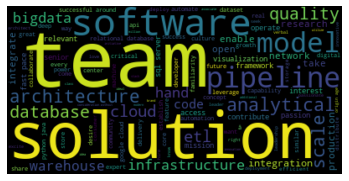

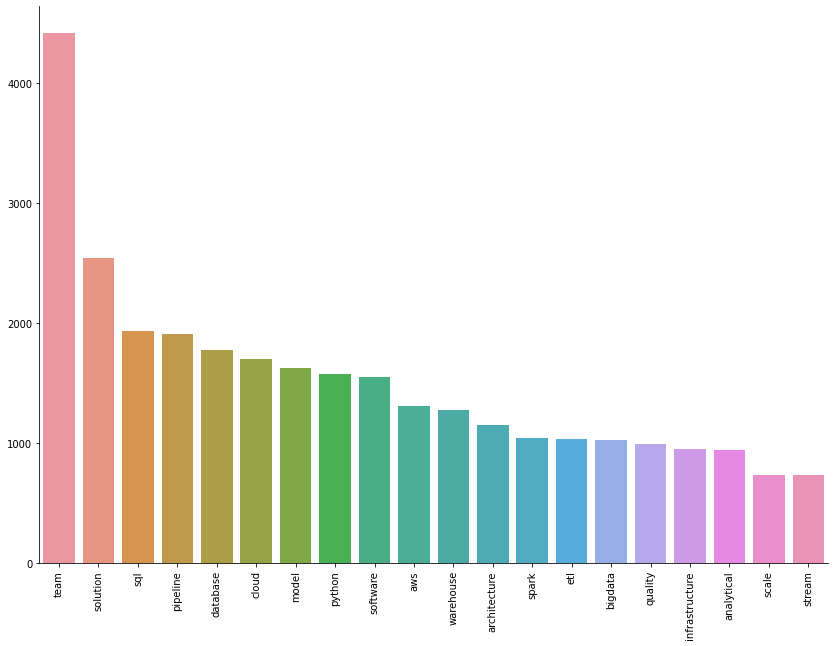



Data Scientist


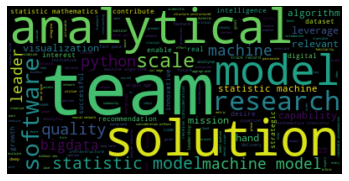

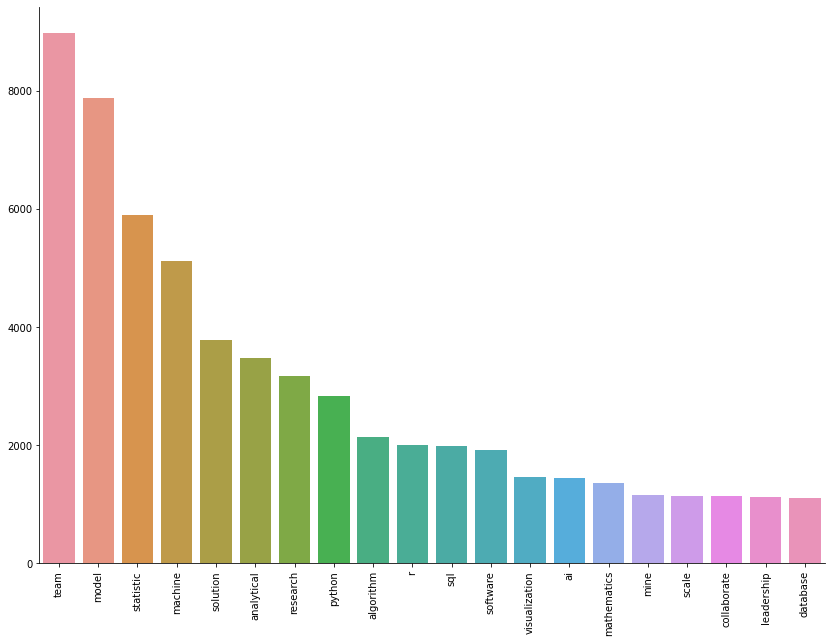



Business Analyst


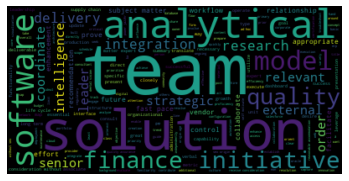

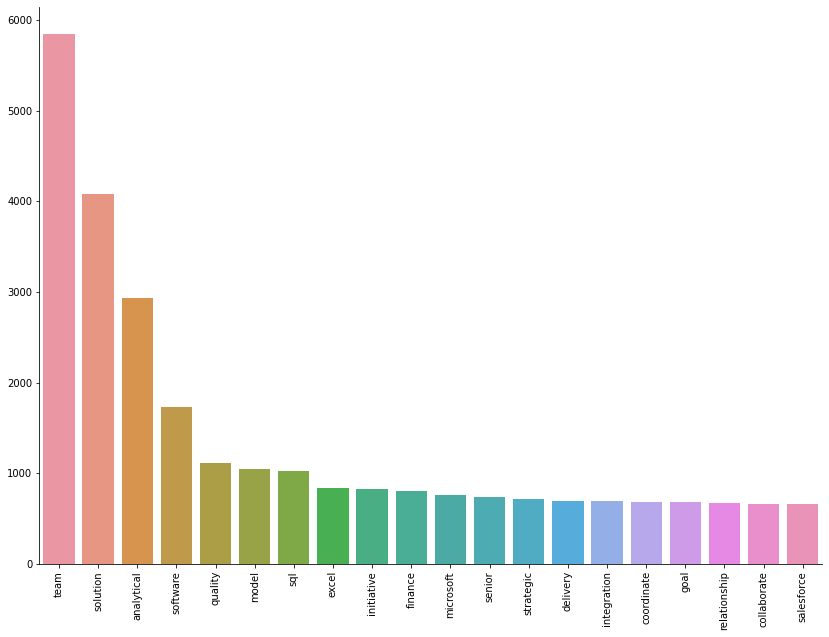



Analyst


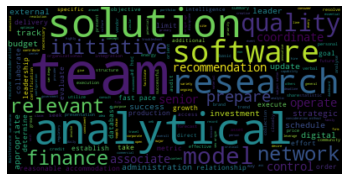

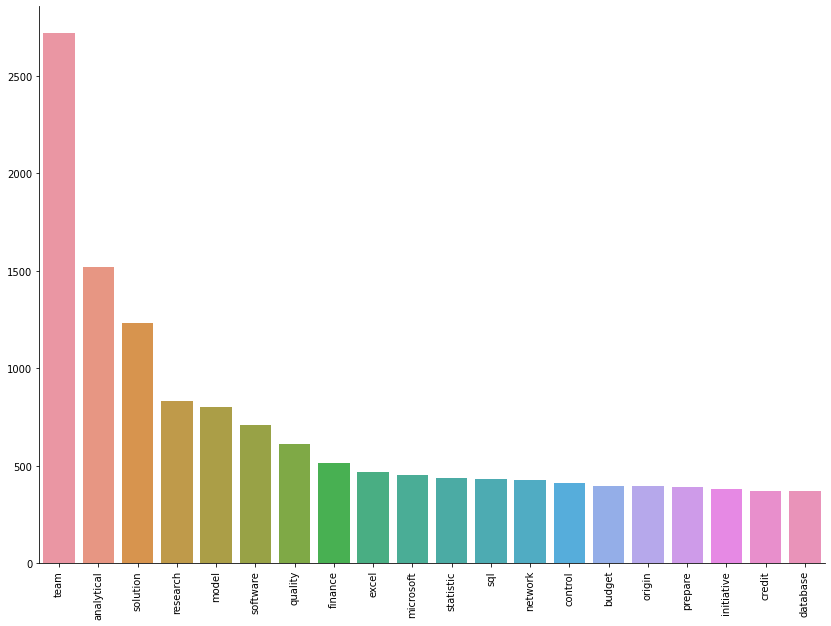



Data Analyst


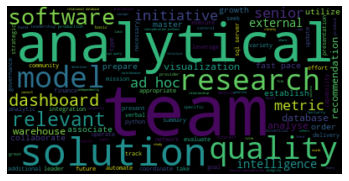

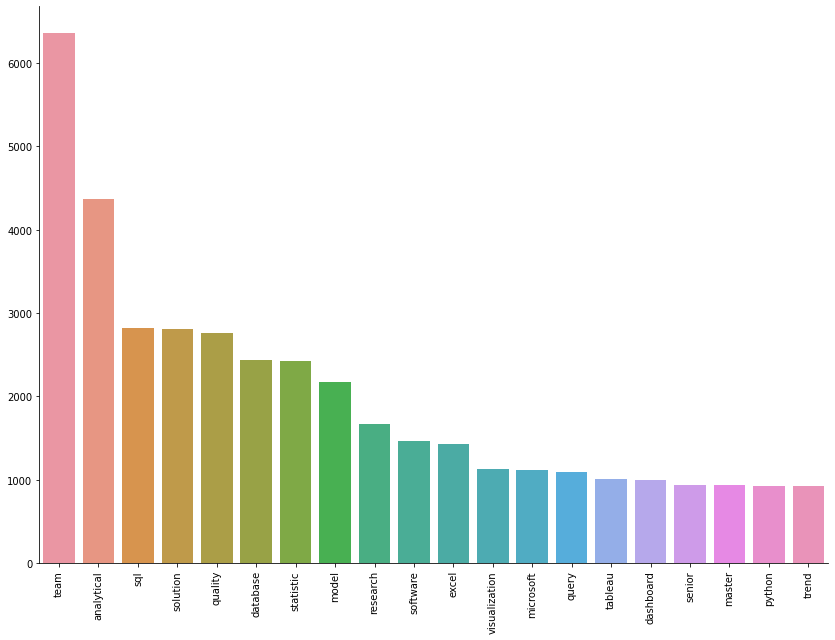

In [45]:
#job title word clouds
from wordcloud import WordCloud
#collocations=False
# filterList=[]
def fun(x):
    if x is None:
        return ""
    wordList.append(x)
    
jt=['Data Engineer', 'Data Scientist', 'Business Analyst', 'Analyst', 'Data Analyst']

for job in jt:
    wordList=[]
    FDSword.loc[FDSword['edit_jobTitle']==job]['edit_jobDescription'].dropna().apply(lambda x: fun(x))   
    abc=" ".join(wordList)
    wordcloud = WordCloud().generate(abc)
    # Display the generated image:      
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    print(job)
    plt.show()
    print("\n")
    words=pd.Series(abc.split())
    info=words.value_counts().sort_values(ascending=False).head(20)
    g =sns.catplot(x=info.index,y=info.values,kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
    g.set_xticklabels(rotation=90)
    plt.show()
#     print(f'Top 20 words for {job} are \n{info}')
#     filterList.append(words.value_counts().sort_values(ascending=False).head(25))
    
    print("\n")

# print(filterList)
    

Data Engineer

Top 20 words for Data Engineer are 
- team              4421
- solution          2543
- sql               1933
- pipeline          1911
- database          1775
- cloud             1701
- model             1624
- python            1574
- software          1552
- aws               1308
- warehouse         1280
- architecture      1149
- spark             1041
- etl               1036
- bigdata           1032
- quality            998
- infrastructure     950
- analytical         941
- scale              736
- stream             736



Data Scientist

Top 20 words for Data Scientist are 
- team             8974
- model            7868
- statistic        5889
- machine          5121
- solution         3783
- analytical       3469
- research         3179
- python           2828
- algorithm        2136
- r                2011
- sql              1979
- software         1922
- visualization    1458
- ai               1441
- mathematics      1369
- mine             1153
- scale            1146
- collaborate      1138
- leadership       1120
- database         1111



Business Analyst

Top 20 words for Business Analyst are 
- team            5851
- solution        4080
- analytical      2939
- software        1736
- quality         1111
- model           1046
- sql             1023
- excel            834
- initiative       833
- finance          805
- microsoft        758
- senior           735
- strategic        719
- delivery         692
- integration      691
- coordinate       684
- goal             682
- relationship     677
- collaborate      659
- salesforce       658



Analyst

Top 20 words for Analyst are 
- team          2721
- analytical    1518
- solution      1230
- research       830
- model          803
- software       707
- quality        614
- finance        512
- excel          470
- microsoft      454
- statistic      438
- sql            432
- network        425
- control        410
- budget         398
- origin         395
- prepare        393
- initiative     380
- credit         371
- database       370



Data Analyst

Top 20 words for Data Analyst are 
- team             6360
- analytical       4363
- sql              2822
- solution         2811
- quality          2764
- database         2440
- statistic        2425
- model            2172
- research         1669
- software         1468
- excel            1424
- visualization    1134
- microsoft        1121
- query            1088
- tableau          1011
- dashboard         998
- senior            941
- master            932
- python            929
- trend             924


### Job Title

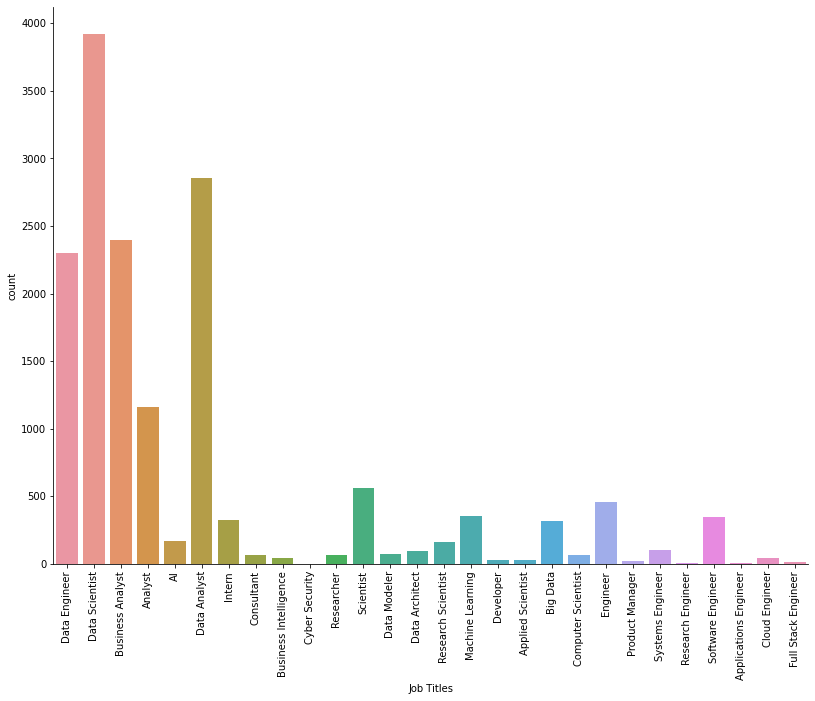

In [46]:
titles =sns.catplot(x="edit_jobTitle",kind="count", data=FDSword, height=8.27, aspect=11.7/8.27 )
titles.set_xticklabels(rotation=90)
titles.set(xlabel='Job Titles') ;

### Salary Visuals

#### by Job Title

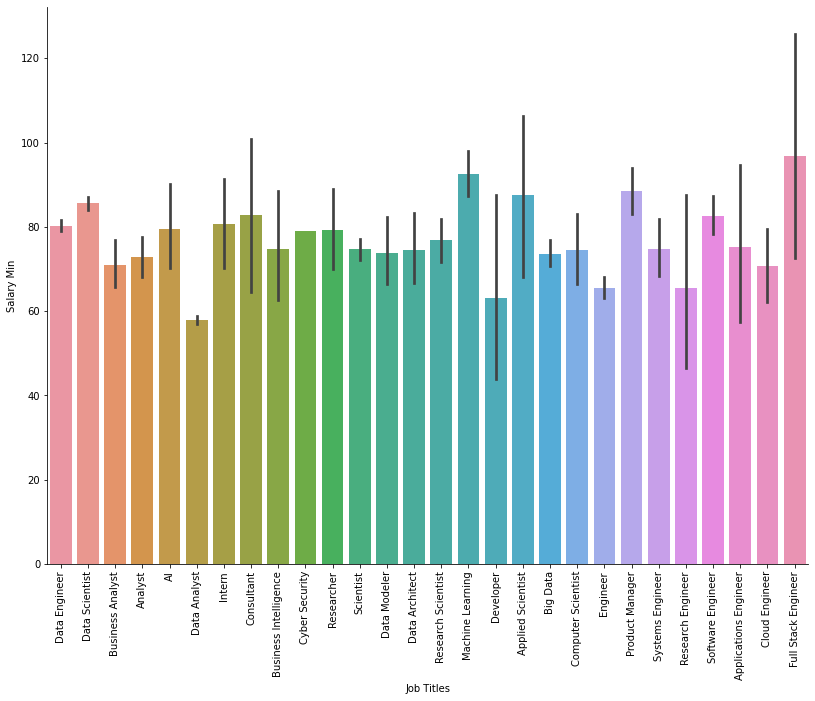

In [47]:
#plot salary info
mini =sns.catplot(x="edit_jobTitle",y="SalaryMin",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
mini.set_xticklabels(rotation=90)
mini.set(xlabel='Job Titles', ylabel='Salary Min') ;

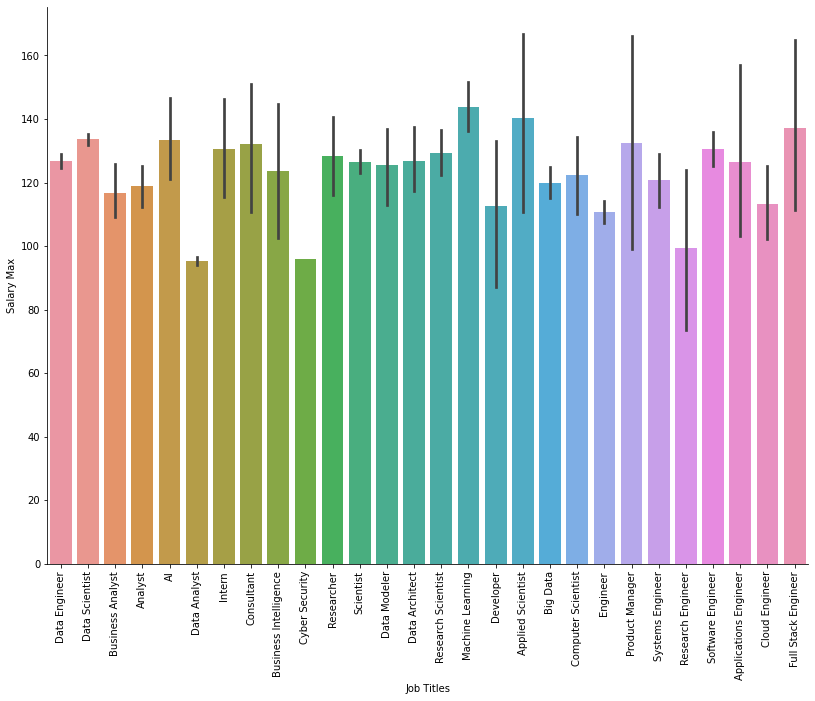

In [48]:
maxi =sns.catplot(x="edit_jobTitle",y="SalaryMax",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
maxi.set_xticklabels(rotation=90)
maxi.set(xlabel='Job Titles', ylabel='Salary Max') ;

#### by State

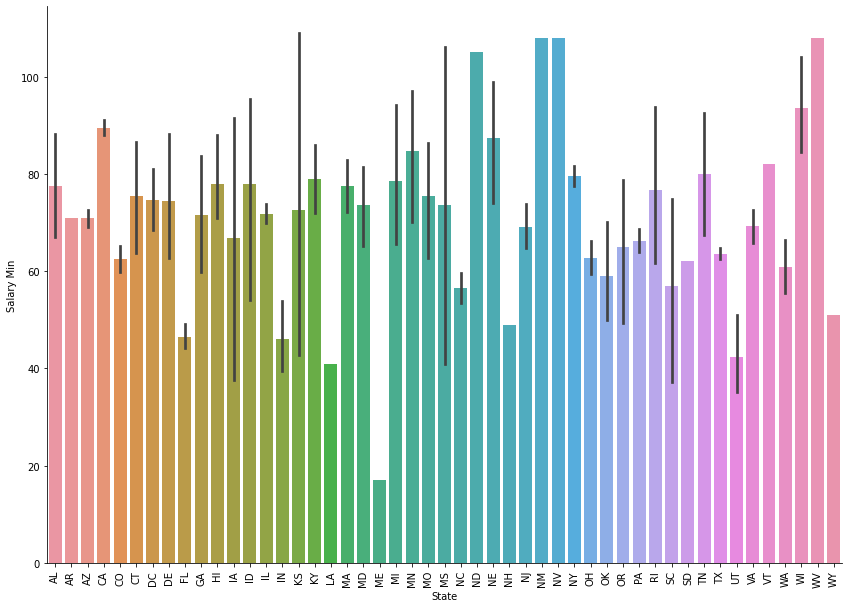

In [49]:
# category_order = uniqueState[~np.isnan(uniqueState)]
category_order = ['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

miniState =sns.catplot(x="State",y="SalaryMin",kind="bar", order=category_order, data=FDSword, height=8.27, aspect=11.7/8.27 )
miniState.set_xticklabels(rotation=90)
miniState.set(ylabel='Salary Min') ;


In [50]:
state_geo = 'us-states.json'

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=FDSstate,
    columns=['State', 'SalaryMin'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Min Salary'
).add_to(m)

folium.LayerControl().add_to(m)
m.save("minSal_state.html")
m

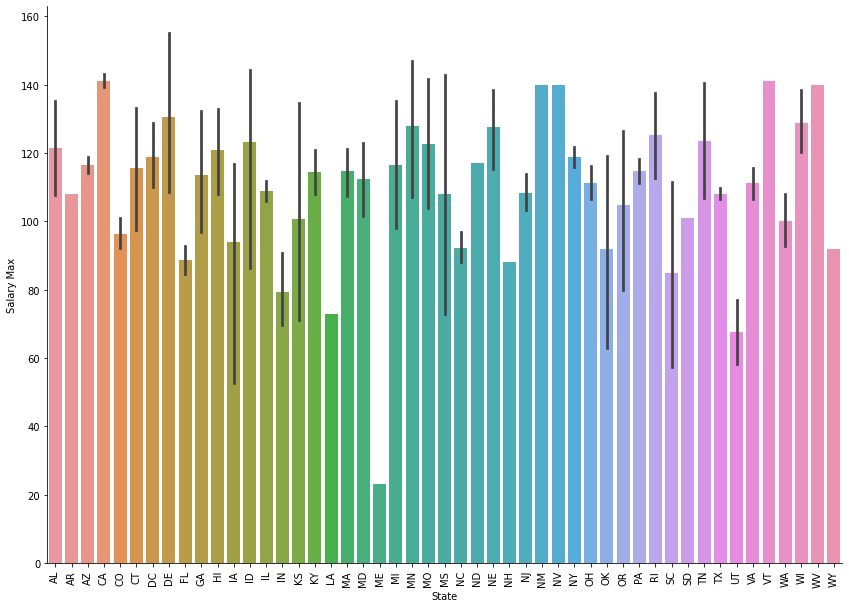

In [51]:
maxiState =sns.catplot(x="State",y="SalaryMax",kind="bar", order=category_order, data=FDSword, height=8.27, aspect=11.7/8.27 )
maxiState.set_xticklabels(rotation=90)
maxiState.set(ylabel='Salary Max') ;

In [52]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=FDSstate,
    columns=['State', 'SalaryMax'],
    key_on='feature.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Max Salary'
).add_to(m)

folium.LayerControl().add_to(m)
m.save("maxSal_state.html")
m

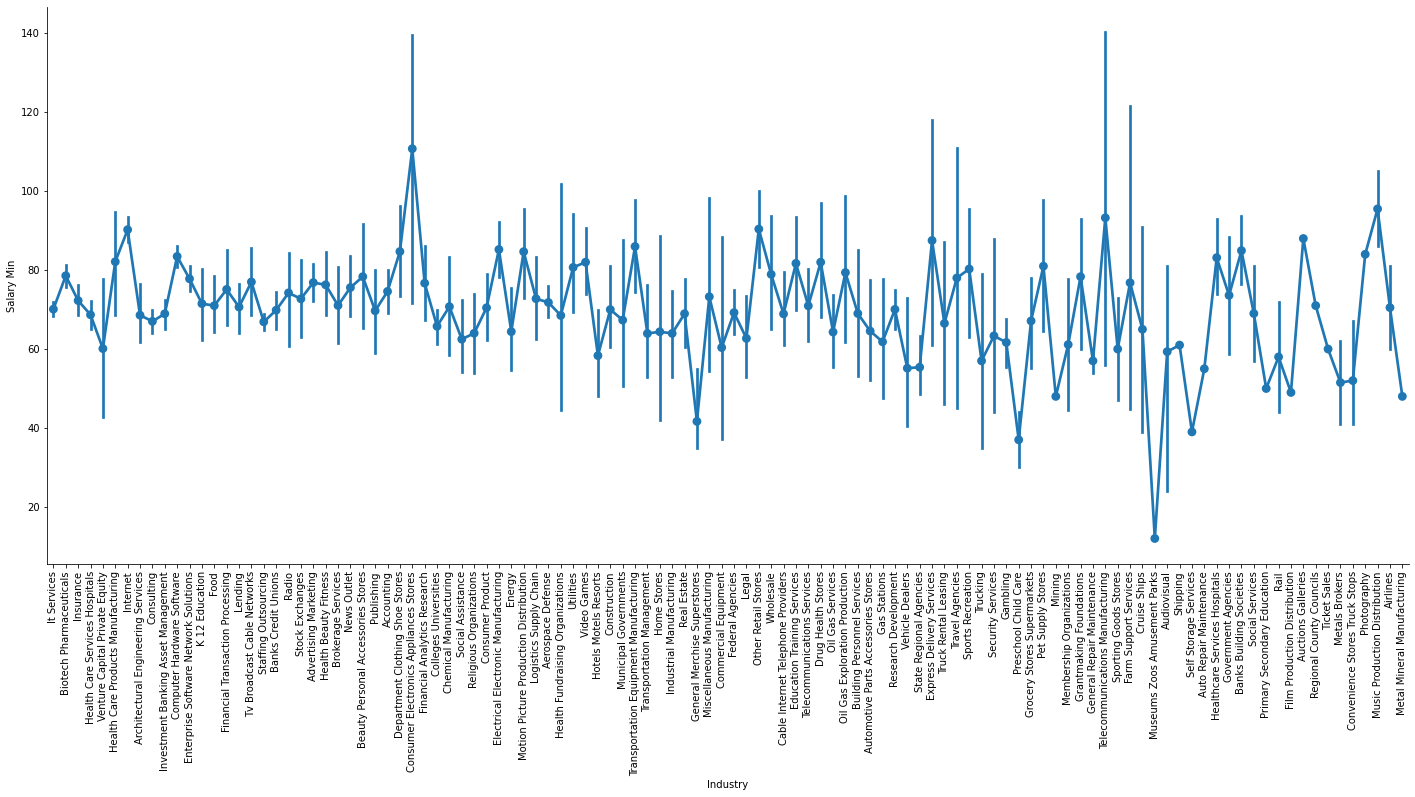

In [68]:
#plot min salary info
miniIndus =sns.catplot(x="indus",y="SalaryMin",kind="point", data=FDSword, height=8.27, aspect=20.7/8.27 )
miniIndus.set_xticklabels(rotation=90)
miniIndus.set(xlabel='Industry', ylabel='Salary Min') ;

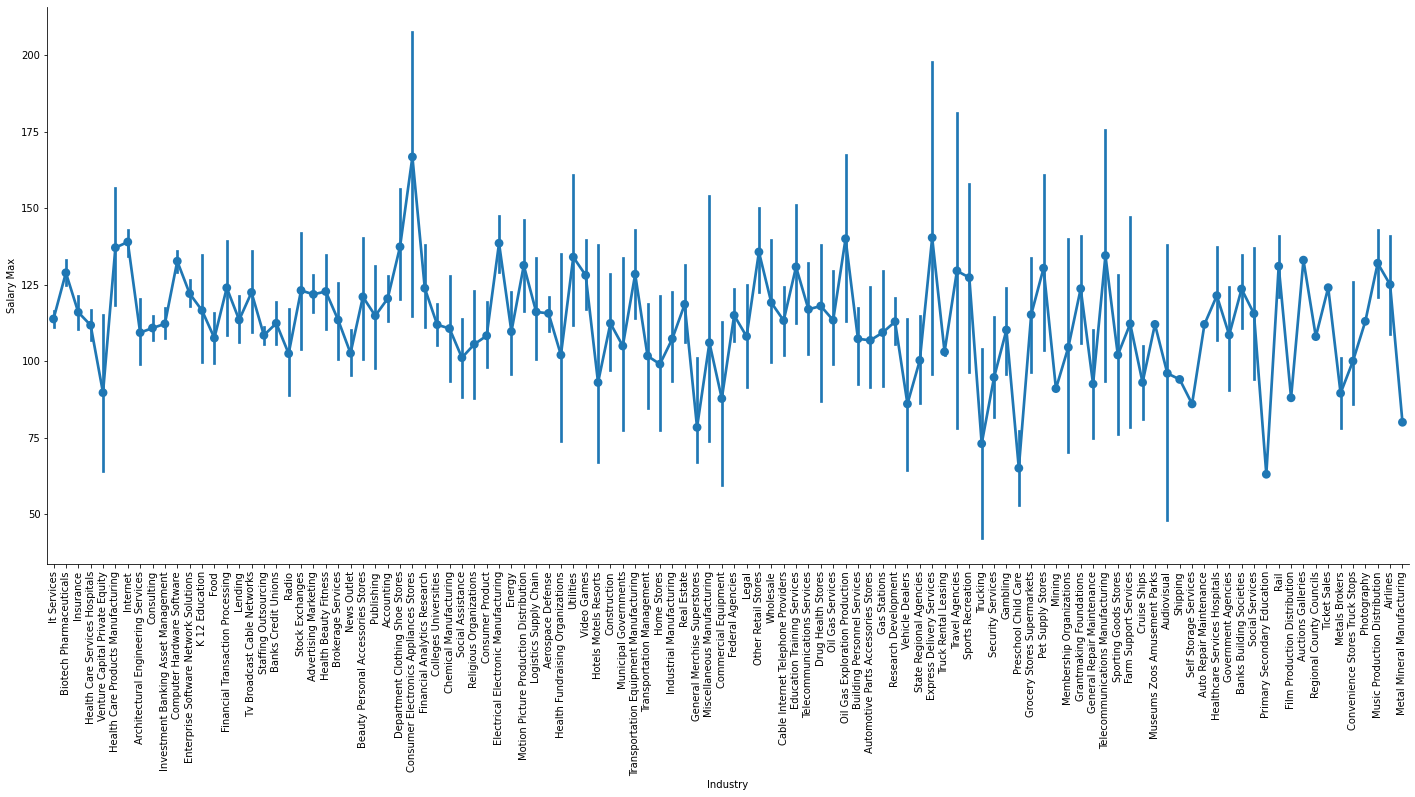

In [69]:
#plot max salary info
maxIndus =sns.catplot(x="indus",y="SalaryMax",kind="point", data=FDSword, height=8.27, aspect=20.7/8.27 )
maxIndus.set_xticklabels(rotation=90)
maxIndus.set(xlabel='Industry', ylabel='Salary Max') ;

### Rating

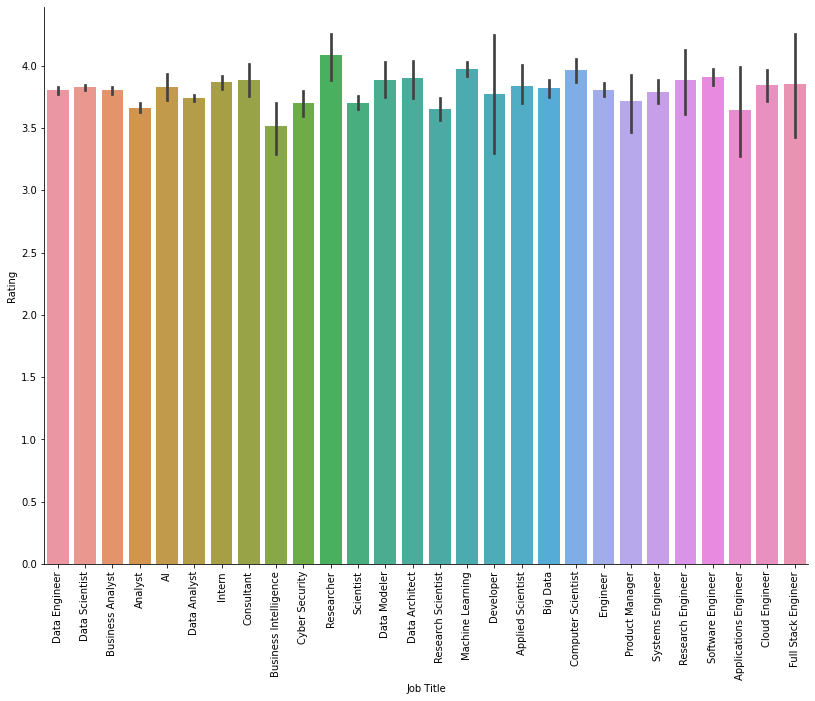

In [55]:
rateTitle =sns.catplot(x="edit_jobTitle",y="Rating",kind="bar", data=FDSword, height=8.27, aspect=11.7/8.27 )
rateTitle.set_xticklabels(rotation=90)
rateTitle.set(xlabel='Job Title',ylabel='Rating') ;

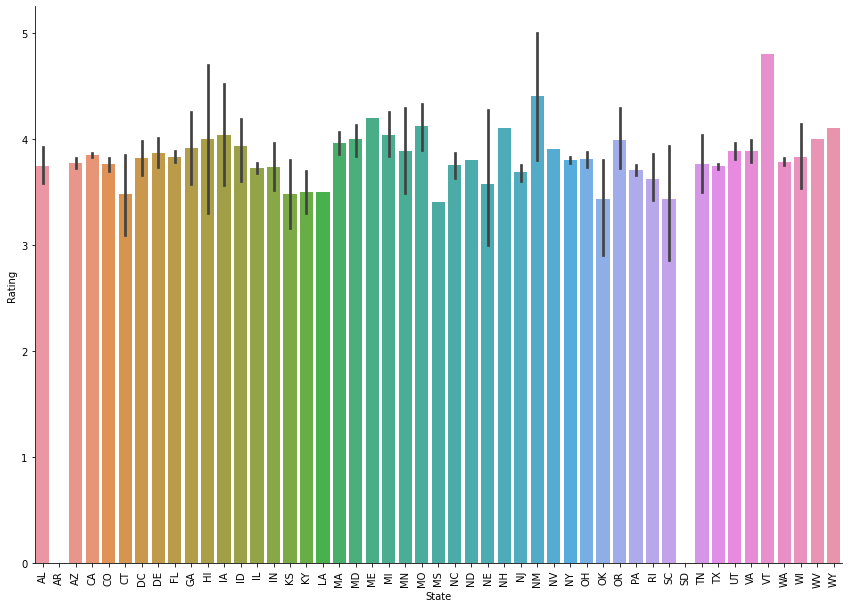

In [56]:
rateState =sns.catplot(x="State",y="Rating",kind="bar", order=category_order, data=FDSword, height=8.27, aspect=11.7/8.27 )
rateState.set_xticklabels(rotation=90)
rateState.set(ylabel='Rating') ;

In [57]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=FDSstate,
    columns=['State', 'Rating'],
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Rating'
).add_to(m)

folium.LayerControl().add_to(m)
m.save("rating_state.html")
m

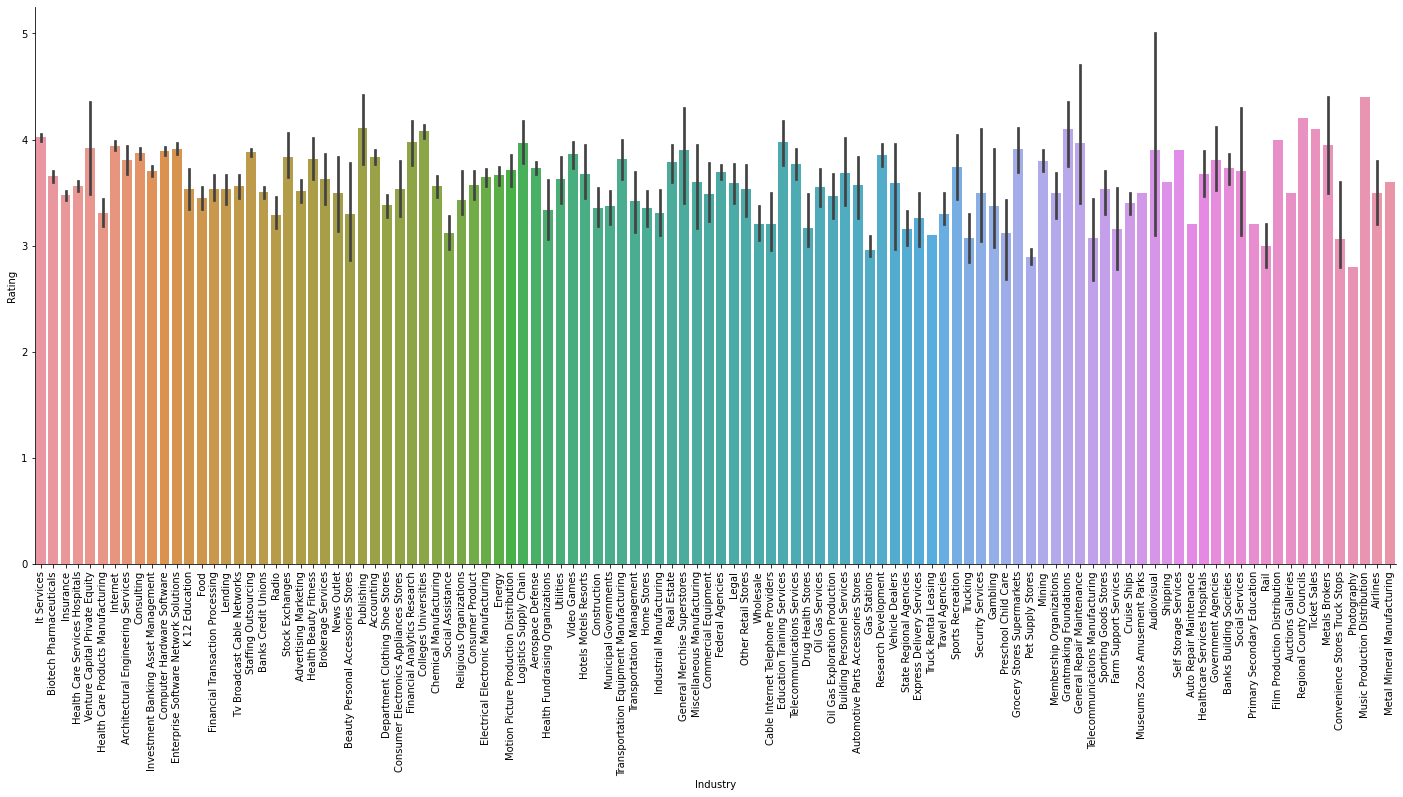

In [58]:
rateIndus =sns.catplot(x="indus",y="Rating",kind="bar", data=FDSword, height=8.27, aspect=20.7/8.27 )
rateIndus.set_xticklabels(rotation=90)
rateIndus.set(xlabel='Industry', ylabel='Rating') ;

## City Visualizations

#### Min Salary by City (color and size are min salary)

In [64]:
import plotly.graph_objects as go


Fullcity['text'] = Fullcity['name'] + '<br>Min Salary ' + (Fullcity['SalaryMin']*1000).astype(str)+' dollars\n' +'<br>Cost of Living ' + (Fullcity['Cost of Living Index']*1000).astype(str) +' dollars\n'
limits = [(0,50),(51,60),(61,70),(71,80),(81,90), (91,100), (101,150), (151,200)]
colors = ["royalblue","crimson","lightseagreen","orange","red",'yellow', 'green', 'black']
cities = []
scale = 1000

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    Fullcity_sub =Fullcity[(Fullcity['SalaryMin']>lim[0]) & (Fullcity['SalaryMin']<lim[1])]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = Fullcity_sub['lon'],
        lat = Fullcity_sub['lat'],
        text = Fullcity_sub['text'],
        marker = dict(
            size = Fullcity_sub['SalaryMin'],
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = 'US city Min Salary<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

#### Min Salary by City and Job Count (color is by min salary and size of bubble is by job count )

In [65]:
Fullcity['text'] = Fullcity['name']+ ' # of Jobs: '+Fullcity['count'].astype(str)+ '<br>Min Salary ' + '$'+(round(Fullcity['SalaryMin']*1000,2)).astype(str) +'<br>Max Salary ' + '$'+(round(Fullcity['SalaryMax']*1000,2)).astype(str)+'<br>Cost of Living ' + '$'+(round(Fullcity['Cost of Living Index']*1000,2)).astype(str) +'<br>Local Purchasing Power Index ' + '$'+(round(Fullcity['Local Purchasing Power Index']*1000,2)).astype(str) 

limits = [(0,50),(51,60),(61,70),(71,80),(81,90), (91,100), (101,150), (151,200)]
colors = ["royalblue","crimson","lightseagreen","orange","red",'yellow', 'green', 'black']
cities = []
scale = 1000

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    Fullcity_sub =Fullcity[(Fullcity['SalaryMin']>lim[0]) & (Fullcity['SalaryMin']<lim[1])]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = Fullcity_sub['lon'],
        lat = Fullcity_sub['lat'],
        text = Fullcity_sub['text'],
        marker = dict(
            size = Fullcity_sub['count'],
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = 'US Data Scientist Jobs by City<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

#### Min Salary by City and Cost of Living Index (color is by min salary and size of bubble is by Cost of Living Index)

In [66]:

Fullcity.dropna(subset=['Cost of Living Index'],inplace=True)
Fullcity['text'] = Fullcity['name']+ ' # of Jobs: '+Fullcity['count'].astype(str)+ '<br>Min Salary ' + '$'+(round(Fullcity['SalaryMin']*1000,2)).astype(str) +'<br>Max Salary ' + '$'+(round(Fullcity['SalaryMax']*1000,2)).astype(str)+'<br>Cost of Living ' + '$'+(round(Fullcity['Cost of Living Index']*1000,2)).astype(str) +'<br>Local Purchasing Power Index ' + '$'+(round(Fullcity['Local Purchasing Power Index']*1000,2)).astype(str) 

limits = [(0,50),(51,60),(61,70),(71,80),(81,90), (91,100), (101,150), (151,200)]
colors = ["royalblue","crimson","lightseagreen","orange","red",'yellow', 'green', 'black']
cities = []
scale = 1000

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    Fullcity_sub =Fullcity[(Fullcity['SalaryMin']>lim[0]) & (Fullcity['SalaryMin']<lim[1])]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = Fullcity_sub['lon'],
        lat = Fullcity_sub['lat'],
        text = Fullcity_sub['text'],
        marker = dict(
            size = Fullcity_sub['Cost of Living Index'],
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = 'US Data Scientist Jobs by City and Cost of Living<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()